<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 1

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from typing import List, Dict, Tuple, Set
import shutil

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [ ]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase1/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.441070,0.005,0.0,shippingservice-0
1,1647619320,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.455602,0.005,0.0,shippingservice-0
2,1647619380,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.546195,0.000,0.0,shippingservice-0
3,1647619440,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.352804,0.010,0.0,shippingservice-0
4,1647619500,0.0,204.0,256.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,25.0,0.0,256.0,0.0,0.446267,0.000,0.0,shippingservice-0


In [ ]:
# describe numerical metrics of train dataset
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,...,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,...,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,...,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,100000.0,0.0,15.000000,0.0,128.000000,0.0,0.049372,0.000000,0.0
25%,1.647641e+09,0.0,102.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,25.000000,100000.0,0.0,21.000000,0.0,224.000000,0.0,0.381905,0.010000,0.0
50%,1.647662e+09,0.0,204.000000,256.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,98.000000,100000.0,0.0,27.000000,0.0,256.000000,0.0,0.939109,0.025000,0.0
75%,1.647684e+09,0.0,204.000000,465.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,174.000000,100000.0,0.0,29.000000,0.0,465.500000,0.0,1.738056,0.055000,0.0
max,1.647706e+09,0.0,409.000000,1025.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,506.000000,100000.0,0.0,41.000000,0.0,1025.000000,0.0,8.847941,0.670000,0.0


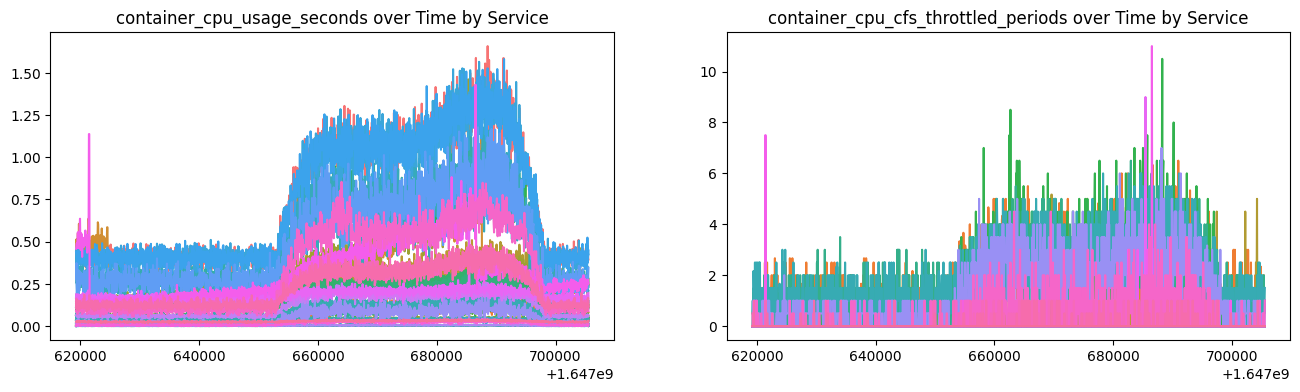

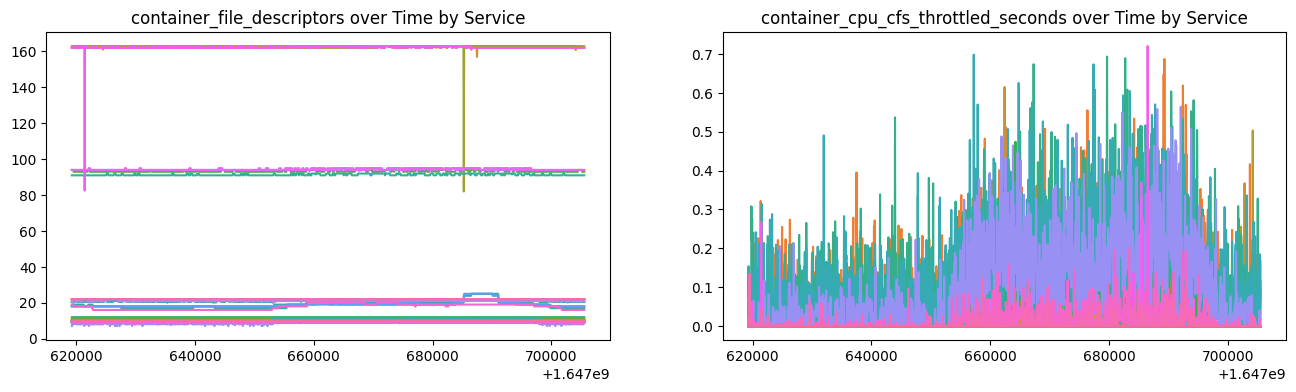

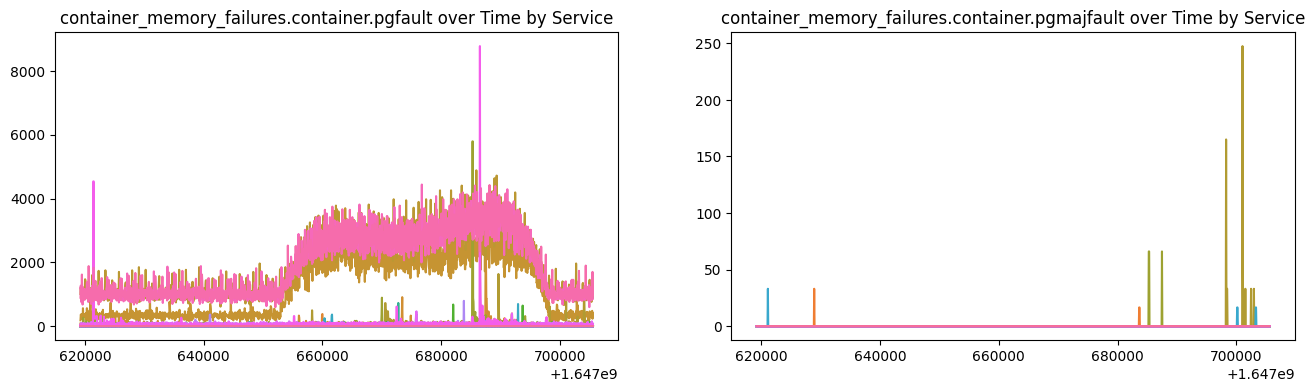

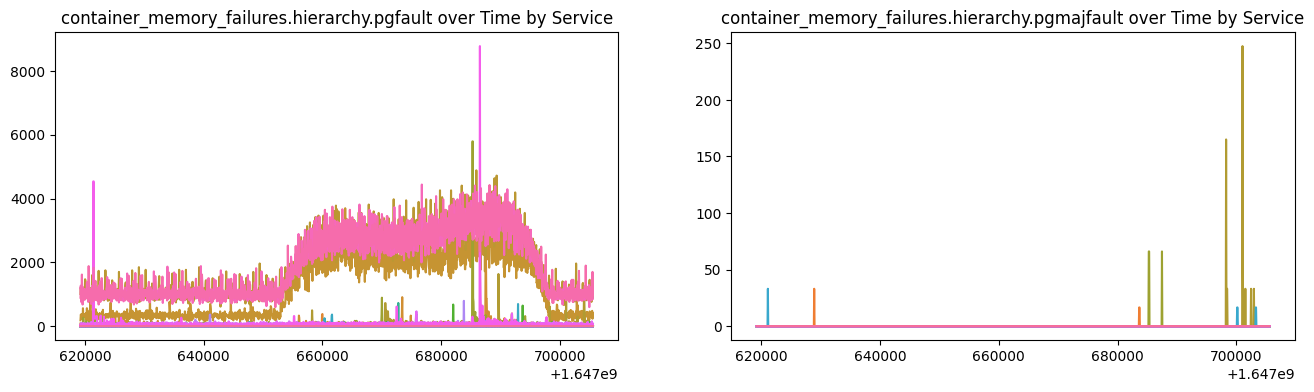

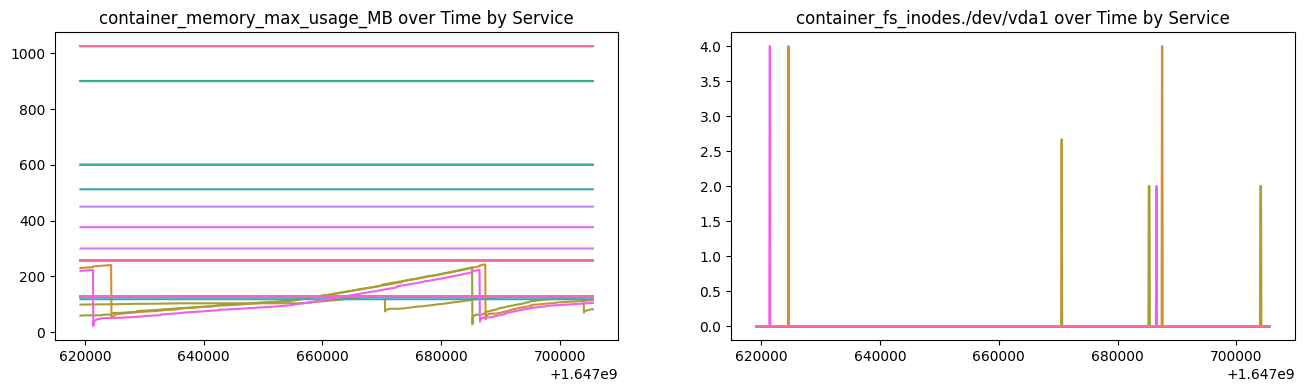

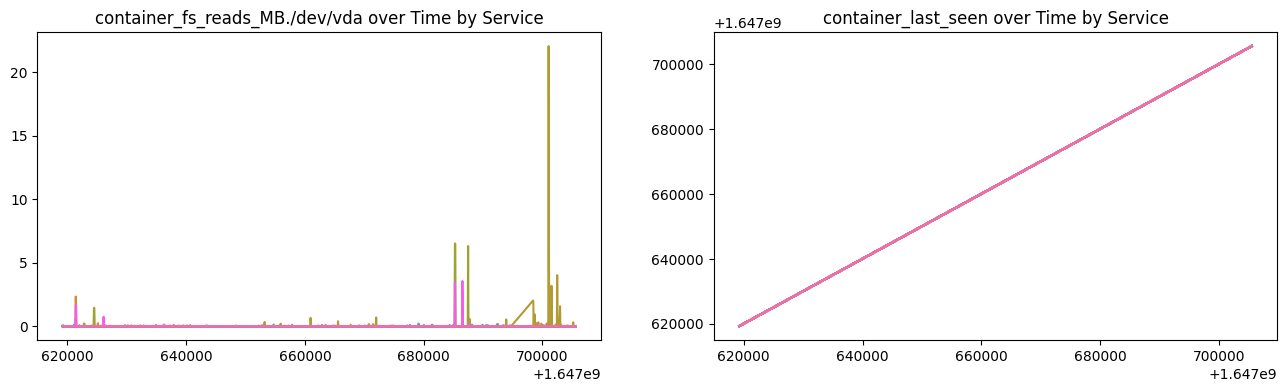

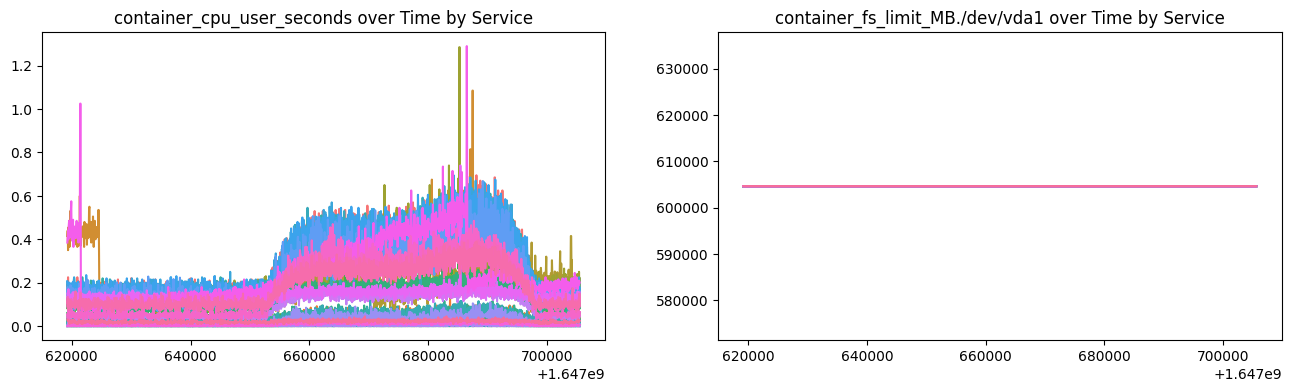

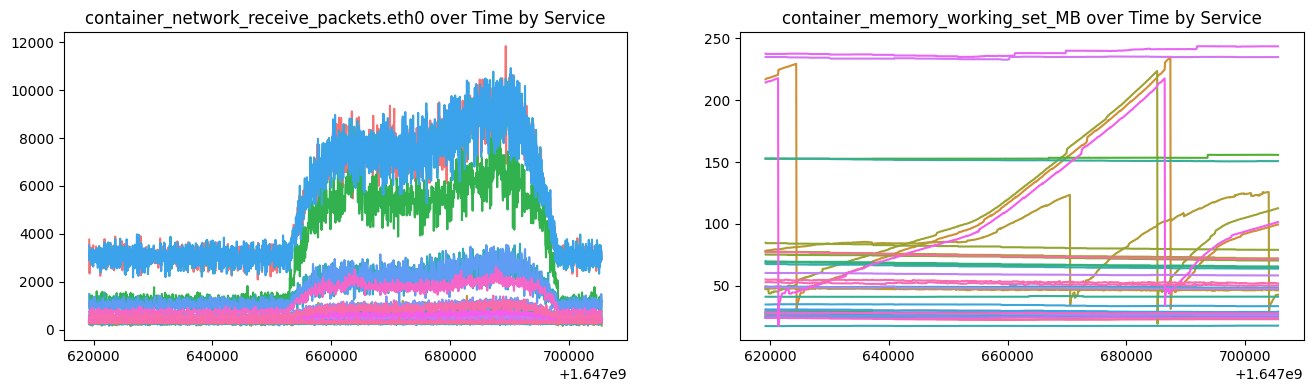

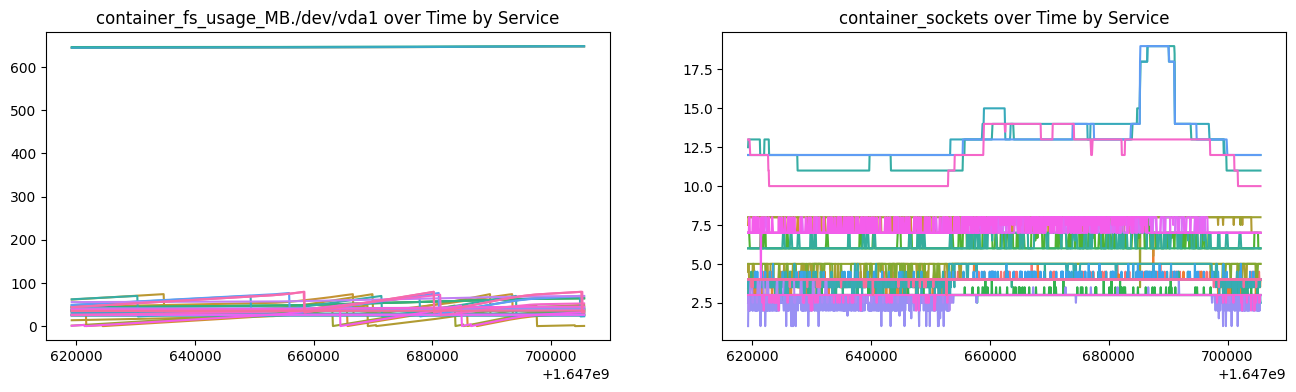

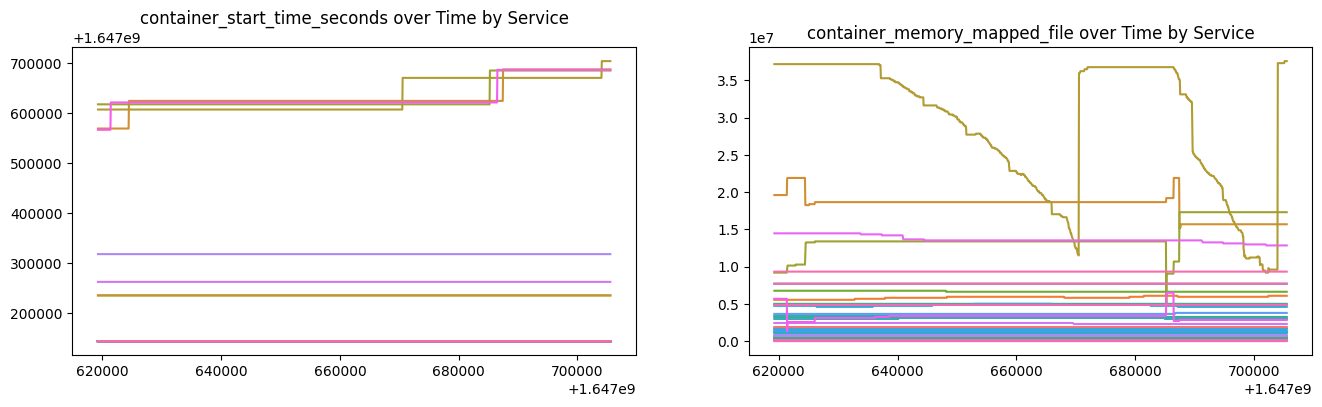

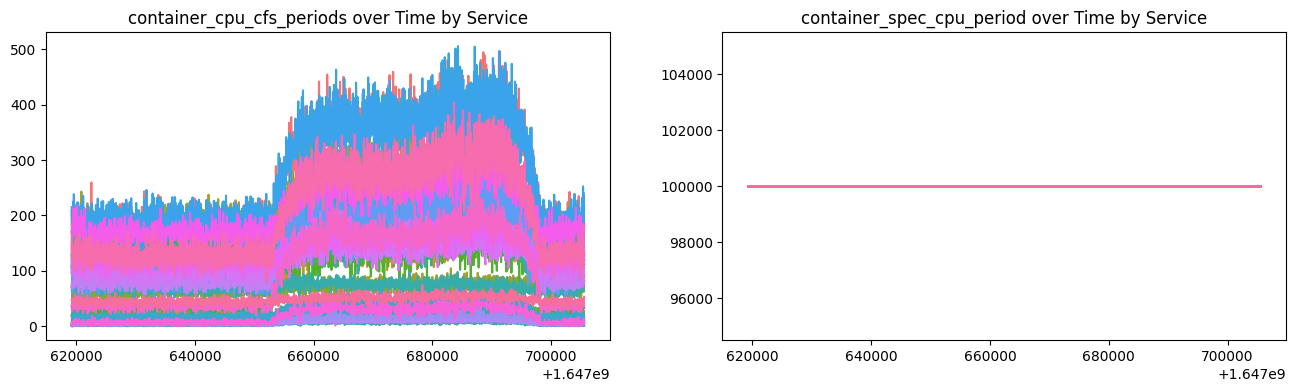

In [ ]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [3]:
class DataManager:
    def __init__(self, data_path: str, train: bool = False, ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data = {}
        self.columns = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __normalize_data(self, data: np.ndarray):
        # Subtract the mean from each column
        if self.train:
          mean = np.mean(data, axis=0)
          std = np.std(data, axis=0)
          normalized_data = (data - mean) / (std + 1e-8)
        else:
          mean = np.mean(data[:15], axis=0)
          std = np.std(data[:15], axis=0)
          normalized_data = (data - mean) / (std + 1e-8)

        return normalized_data

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            raw_data = cur_df[self.columns].values

            # Normalize the data to have the same mean distribution
            normalized_data = self.__normalize_data(raw_data)

            self.data[file[:-4]] = normalized_data

    def get(self, s: str) -> np.ndarray:
        return self.data[s]


###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomaly and their anomaly scores.





In [4]:
# creates sequences of the data
def to_sequences(x, seq_size=1):
    x_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x[i:(i+seq_size)])

    return np.array(x_values)


class LSTMAEDetector:
    def __init__(self):
        self.model = Sequential()
        self.med_loss = 1

    def fit(self, data: np.ndarray):
        train_x = to_sequences(data, 10)

        self.model.add(LSTM(128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(LSTM(32, return_sequences=False))
        self.model.add(Dropout(rate=0.2))
        self.model.add(RepeatVector(train_x.shape[1]))
        self.model.add(LSTM(32, return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(LSTM(128, return_sequences=True))
        self.model.add(Dropout(rate=0.2))
        self.model.add(TimeDistributed(Dense(train_x.shape[2])))
        self.model.compile(optimizer='adam', loss='mae')

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', start_from_epoch=10)

        self.model.fit(train_x, train_x, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[earlystop])

        predict = self.model.predict(train_x)
        loss = np.mean(np.abs(predict - train_x), axis=1)
        self.med_loss = np.median(loss)

    def decision_function(self, data: np.ndarray):
        test_x = to_sequences(data, 10)

        predict = self.model.predict(test_x, verbose=0)
        loss = (np.mean(np.abs(predict - test_x), axis=(1, 2))) / self.med_loss
        return loss


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, LSTMAEDetector] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = LSTMAEDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            scores = self.detector_dict[k].decision_function(v)

            assert type(scores) == np.ndarray
            anomaly_scores[k] = scores

        return anomaly_scores

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice, the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes. However, that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [5]:
def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)


class Ranker:
    def __init__(self, hyper_params, anomaly_detector):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'], train=True)
        self.anomaly_detector = anomaly_detector

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        container_score = {container: np.mean(score) for container, score in anomaly_score.items()}
        max_anomaly = max(container_score, key=container_score.get)

        services = list(anomaly_score.keys())

        corr = np.zeros(len(services))
        score = np.empty(len(services))       
        
        # Nodes all start at 1. Edeges initialized based on topology and correlations.
        nodes = np.ones(len(services))
        edges = np.zeros((len(services), len(services)))
        c = 0.9

        with open(self.hyper_params['topology'], 'rt') as f:
            topology = json.load(f)

        for i, service in enumerate(services):
            score[i] = container_score[service]
            for key, values in topology.items():
                if service.startswith(key):
                    for value in values:
                        for j, s in enumerate(services):
                            if s.startswith(value):
                                # Edge from parent to child in topology: corrolation between parent and child
                                edges[i][j] = find_correlation(test_data.data[service], test_data.data[s])
                                edges[j][i] = max(0, find_correlation(test_data.data[service][:15], test_data.data[s][:15]) - edges[i][j])

        # Edge to stay in node: max of incoming edges minus max of outgoing edges (capped at 0)
        np.fill_diagonal(edges, np.maximum(0, edges.max(axis=1) - edges.max(axis=0)))

        # Normalisation
        edges = (edges / (edges.sum(axis=0) + 1e-5))
        score = score / score.sum()
        #nodes = np.copy(score)

        # Random walk
        for _ in range(50):
            nodes = c*np.matmul(nodes, edges) + (1-c)*score
        
        # Find scores
        scores = {services[i]: nodes[i] for i in range(len(services))}

        return sorted(list(scores.keys()), key=lambda x: scores[x], reverse=True)


###3.4 Training

In [6]:
hyper_params = {
    'train_dir': 'phase1/dataset/train/processed',
    'test_dir': 'phase1/dataset/test/processed',
    'label_path': 'phase1/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}

anomaly_detector = AnomalyDetector(hyper_params)
anomaly_detector.fit(DataManager(hyper_params['train_dir'], True))

Fitting detector(s):   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1/50
41/41 [==============================] - 14s 43ms/step - loss: 0.2005 - val_loss: 0.1894
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1387 - val_loss: 0.1789
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1163 - val_loss: 0.1684
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1039 - val_loss: 0.1575
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0950 - val_loss: 0.1544
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0893 - val_loss: 0.1478
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0838 - val_loss: 0.1450
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0805 - val_loss: 0.1432
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0780 - val_loss: 0.1363
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0758 - val_loss: 0.1360
Epoch 11

Fitting detector(s):   2%|▏         | 1/42 [00:31<21:41, 31.74s/it]

Epoch 1/50
41/41 [==============================] - 9s 39ms/step - loss: 0.1647 - val_loss: 0.1873
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.1768
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1222 - val_loss: 0.1653
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1152 - val_loss: 0.1403
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1104 - val_loss: 0.1319
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1066 - val_loss: 0.1303
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1037 - val_loss: 0.1260
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1011 - val_loss: 0.1215
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0993 - val_loss: 0.1262
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0975 - val_loss: 0.1196
Epoch 11/50

Fitting detector(s):   5%|▍         | 2/42 [00:49<15:52, 23.81s/it]

Epoch 1/50
41/41 [==============================] - 8s 38ms/step - loss: 0.2149 - val_loss: 0.1959
Epoch 2/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1593 - val_loss: 0.1787
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1339 - val_loss: 0.1714
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1197 - val_loss: 0.1658
Epoch 5/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1098 - val_loss: 0.1604
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1020 - val_loss: 0.1586
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0954 - val_loss: 0.1551
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0902 - val_loss: 0.1550
Epoch 9/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0866 - val_loss: 0.1539
Epoch 10/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0844 - val_loss: 0.1531
Epoch 11/50
4

Fitting detector(s):   7%|▋         | 3/42 [01:12<15:10, 23.36s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.2270 - val_loss: 0.3916
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1655 - val_loss: 0.3813
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1399 - val_loss: 0.3777
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1267 - val_loss: 0.3668
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1186 - val_loss: 0.3692
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1122 - val_loss: 0.3679
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1073 - val_loss: 0.3492
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1038 - val_loss: 0.3417
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1007 - val_loss: 0.3260
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0993 - val_loss: 0.3320
Epoch 11/50

Fitting detector(s):  10%|▉         | 4/42 [01:31<13:34, 21.43s/it]

Epoch 1/50
41/41 [==============================] - 8s 53ms/step - loss: 0.2076 - val_loss: 0.1811
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1551 - val_loss: 0.1569
Epoch 3/50
41/41 [==============================] - 0s 12ms/step - loss: 0.1332 - val_loss: 0.1464
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.1431
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1126 - val_loss: 0.1357
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1064 - val_loss: 0.1331
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1018 - val_loss: 0.1316
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0978 - val_loss: 0.1261
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0954 - val_loss: 0.1244
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0936 - val_loss: 0.1203
Epoch 11/50
4

Fitting detector(s):  12%|█▏        | 5/42 [01:50<12:39, 20.53s/it]

Epoch 1/50
41/41 [==============================] - 9s 39ms/step - loss: 0.2180 - val_loss: 0.1980
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1763 - val_loss: 0.1881
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1562 - val_loss: 0.1843
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1428 - val_loss: 0.1815
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1337 - val_loss: 0.1789
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1271 - val_loss: 0.1803
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1222 - val_loss: 0.1782
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1191 - val_loss: 0.1767
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1168 - val_loss: 0.1740
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1155 - val_loss: 0.1745
Epoch 11/50

Fitting detector(s):  14%|█▍        | 6/42 [02:18<13:58, 23.30s/it]

Epoch 1/50
41/41 [==============================] - 8s 52ms/step - loss: 0.1678 - val_loss: 0.2344
Epoch 2/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1385 - val_loss: 0.1893
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1222 - val_loss: 0.1706
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1135 - val_loss: 0.1645
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1079 - val_loss: 0.1563
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1036 - val_loss: 0.1485
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1003 - val_loss: 0.1446
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0980 - val_loss: 0.1411
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0962 - val_loss: 0.1354
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0951 - val_loss: 0.1304
Epoch 11/50

Fitting detector(s):  17%|█▋        | 7/42 [02:40<13:11, 22.63s/it]

Epoch 1/50
41/41 [==============================] - 8s 39ms/step - loss: 0.1674 - val_loss: 0.2073
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1383 - val_loss: 0.1916
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1192 - val_loss: 0.1851
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1101 - val_loss: 0.1782
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1042 - val_loss: 0.1696
Epoch 6/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0999 - val_loss: 0.1632
Epoch 7/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0965 - val_loss: 0.1590
Epoch 8/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0942 - val_loss: 0.1585
Epoch 9/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0926 - val_loss: 0.1534
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0914 - val_loss: 0.1510
Epoch 11/50


Fitting detector(s):  19%|█▉        | 8/42 [03:08<13:55, 24.58s/it]

Epoch 1/50
41/41 [==============================] - 9s 45ms/step - loss: 0.2118 - val_loss: 0.1290
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1590 - val_loss: 0.1140
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1355 - val_loss: 0.1041
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1244 - val_loss: 0.1059
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1158 - val_loss: 0.0997
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1090 - val_loss: 0.0969
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1038 - val_loss: 0.0914
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0995 - val_loss: 0.0894
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0961 - val_loss: 0.0876
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0937 - val_loss: 0.0830
Epoch 11/5

Fitting detector(s):  21%|██▏       | 9/42 [03:36<14:04, 25.59s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.1935 - val_loss: 0.2292
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1269 - val_loss: 0.2260
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1009 - val_loss: 0.1900
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0883 - val_loss: 0.1702
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0806 - val_loss: 0.1715
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0749 - val_loss: 0.1498
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.1376
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0677 - val_loss: 0.1476
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0660 - val_loss: 0.1530
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0644 - val_loss: 0.1079
Epoch 11/50
4

Fitting detector(s):  24%|██▍       | 10/42 [03:54<12:24, 23.26s/it]

Epoch 1/50
41/41 [==============================] - 8s 39ms/step - loss: 0.1689 - val_loss: 0.1693
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1361 - val_loss: 0.1564
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1170 - val_loss: 0.1484
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1068 - val_loss: 0.1434
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1000 - val_loss: 0.1427
Epoch 6/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0939 - val_loss: 0.1327
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0897 - val_loss: 0.1258
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0867 - val_loss: 0.1205
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0850 - val_loss: 0.1173
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0839 - val_loss: 0.1175
Epoch 11/

Fitting detector(s):  26%|██▌       | 11/42 [04:22<12:43, 24.64s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.1632 - val_loss: 0.1340
Epoch 2/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1367 - val_loss: 0.1268
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1202 - val_loss: 0.1226
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1113 - val_loss: 0.1195
Epoch 5/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1057 - val_loss: 0.1170
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1018 - val_loss: 0.1164
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0990 - val_loss: 0.1128
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0969 - val_loss: 0.1123
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0953 - val_loss: 0.1109
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0944 - val_loss: 0.1109
Epoch 11/50
41

Fitting detector(s):  29%|██▊       | 12/42 [04:50<12:51, 25.73s/it]

Epoch 1/50
41/41 [==============================] - 9s 39ms/step - loss: 0.1865 - val_loss: 0.2788
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1530 - val_loss: 0.2587
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1364 - val_loss: 0.2404
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1264 - val_loss: 0.2259
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1196 - val_loss: 0.2017
Epoch 6/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1147 - val_loss: 0.1973
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1106 - val_loss: 0.1936
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1082 - val_loss: 0.1801
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1063 - val_loss: 0.1857
Epoch 10/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1050 - val_loss: 0.1789
Epoch 11/50


Fitting detector(s):  31%|███       | 13/42 [05:19<12:56, 26.77s/it]

Epoch 1/50
41/41 [==============================] - 8s 47ms/step - loss: 0.1534 - val_loss: 0.2042
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1122 - val_loss: 0.1991
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0912 - val_loss: 0.1649
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0809 - val_loss: 0.1381
Epoch 5/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0749 - val_loss: 0.1275
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0703 - val_loss: 0.1196
Epoch 7/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0672 - val_loss: 0.1164
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0650 - val_loss: 0.1043
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0634 - val_loss: 0.1080
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0624 - val_loss: 0.1029
Epoch 11/50


Fitting detector(s):  33%|███▎      | 14/42 [05:37<11:09, 23.93s/it]

Epoch 1/50
41/41 [==============================] - 9s 39ms/step - loss: 0.1785 - val_loss: 0.2048
Epoch 2/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1131 - val_loss: 0.1914
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0874 - val_loss: 0.1977
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0754 - val_loss: 0.1763
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0676 - val_loss: 0.1481
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0625 - val_loss: 0.1288
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0583 - val_loss: 0.1274
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0554 - val_loss: 0.1278
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0538 - val_loss: 0.1248
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0525 - val_loss: 0.1186
Epoch 11/50
4

Fitting detector(s):  36%|███▌      | 15/42 [05:55<10:01, 22.27s/it]

Epoch 1/50
41/41 [==============================] - 8s 41ms/step - loss: 0.2043 - val_loss: 0.2770
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1536 - val_loss: 0.2698
Epoch 3/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1335 - val_loss: 0.2526
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1231 - val_loss: 0.2279
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1160 - val_loss: 0.1955
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1106 - val_loss: 0.1852
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1066 - val_loss: 0.1715
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1038 - val_loss: 0.1648
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1019 - val_loss: 0.1573
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1005 - val_loss: 0.1616
Epoch 11/5

Fitting detector(s):  38%|███▊      | 16/42 [06:14<09:10, 21.19s/it]

Epoch 1/50
41/41 [==============================] - 8s 39ms/step - loss: 0.1935 - val_loss: 0.2276
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1387 - val_loss: 0.2090
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1155 - val_loss: 0.1825
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1030 - val_loss: 0.1767
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0955 - val_loss: 0.1689
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0893 - val_loss: 0.1642
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0845 - val_loss: 0.1519
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0808 - val_loss: 0.1389
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0778 - val_loss: 0.1452
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0757 - val_loss: 0.1371
Epoch 11/

Fitting detector(s):  40%|████      | 17/42 [06:43<09:49, 23.56s/it]

Epoch 1/50
41/41 [==============================] - 8s 39ms/step - loss: 0.1945 - val_loss: 0.2577
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1518 - val_loss: 0.2492
Epoch 3/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1343 - val_loss: 0.2245
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1249 - val_loss: 0.1963
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1192 - val_loss: 0.1834
Epoch 6/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1145 - val_loss: 0.1741
Epoch 7/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1110 - val_loss: 0.1610
Epoch 8/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1083 - val_loss: 0.1710
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1065 - val_loss: 0.1552
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1049 - val_loss: 0.1551
Epoch 11/5

Fitting detector(s):  43%|████▎     | 18/42 [07:02<08:55, 22.32s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.1917 - val_loss: 0.1828
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1326 - val_loss: 0.1503
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1062 - val_loss: 0.1300
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0929 - val_loss: 0.1246
Epoch 5/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0836 - val_loss: 0.1148
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0764 - val_loss: 0.1117
Epoch 7/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0703 - val_loss: 0.1073
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0661 - val_loss: 0.1093
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0626 - val_loss: 0.1091
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0606 - val_loss: 0.1101
Epoch 11/50
4

Fitting detector(s):  45%|████▌     | 19/42 [07:20<08:00, 20.91s/it]

Epoch 1/50
41/41 [==============================] - 8s 40ms/step - loss: 0.2066 - val_loss: 0.2030
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1641 - val_loss: 0.1951
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1446 - val_loss: 0.1665
Epoch 4/50
41/41 [==============================] - 1s 13ms/step - loss: 0.1342 - val_loss: 0.1473
Epoch 5/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1270 - val_loss: 0.1381
Epoch 6/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1213 - val_loss: 0.1308
Epoch 7/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1166 - val_loss: 0.1255
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1126 - val_loss: 0.1210
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1098 - val_loss: 0.1181
Epoch 10/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1080 - val_loss: 0.1182
Epoch 11/50

Fitting detector(s):  48%|████▊     | 20/42 [07:38<07:18, 19.92s/it]

Epoch 1/50
41/41 [==============================] - 9s 41ms/step - loss: 0.1679 - val_loss: 0.1885
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1376 - val_loss: 0.1695
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1217 - val_loss: 0.1621
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1136 - val_loss: 0.1581
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1082 - val_loss: 0.1552
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1038 - val_loss: 0.1487
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1013 - val_loss: 0.1492
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0993 - val_loss: 0.1450
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0978 - val_loss: 0.1447
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0968 - val_loss: 0.1406
Epoch 11/

Fitting detector(s):  50%|█████     | 21/42 [08:08<08:05, 23.14s/it]

Epoch 1/50
41/41 [==============================] - 8s 40ms/step - loss: 0.1727 - val_loss: 0.1953
Epoch 2/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1382 - val_loss: 0.1955
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1199 - val_loss: 0.1862
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1081 - val_loss: 0.1695
Epoch 5/50
41/41 [==============================] - 1s 16ms/step - loss: 0.1003 - val_loss: 0.1571
Epoch 6/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0947 - val_loss: 0.1403
Epoch 7/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0905 - val_loss: 0.1368
Epoch 8/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0876 - val_loss: 0.1294
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0857 - val_loss: 0.1304
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0838 - val_loss: 0.1252
Epoch 11/

Fitting detector(s):  52%|█████▏    | 22/42 [08:27<07:16, 21.85s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.2157 - val_loss: 0.2090
Epoch 2/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1597 - val_loss: 0.2103
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.2088
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1213 - val_loss: 0.2025
Epoch 5/50
41/41 [==============================] - 0s 9ms/step - loss: 0.1117 - val_loss: 0.2069
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1039 - val_loss: 0.1967
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0978 - val_loss: 0.1948
Epoch 8/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0935 - val_loss: 0.1910
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0900 - val_loss: 0.1897
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0873 - val_loss: 0.1656
Epoch 11/50

Fitting detector(s):  55%|█████▍    | 23/42 [08:48<06:52, 21.69s/it]

Epoch 1/50
41/41 [==============================] - 9s 50ms/step - loss: 0.1772 - val_loss: 0.2175
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1384 - val_loss: 0.2117
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1179 - val_loss: 0.1981
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1074 - val_loss: 0.1748
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0996 - val_loss: 0.1554
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0940 - val_loss: 0.1491
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0898 - val_loss: 0.1389
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0870 - val_loss: 0.1307
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0850 - val_loss: 0.1296
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0839 - val_loss: 0.1229
Epoch 11/

Fitting detector(s):  57%|█████▋    | 24/42 [09:16<07:03, 23.54s/it]

Epoch 1/50
41/41 [==============================] - 9s 41ms/step - loss: 0.1430 - val_loss: 0.1772
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1180 - val_loss: 0.1661
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1050 - val_loss: 0.1584
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0985 - val_loss: 0.1563
Epoch 5/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0943 - val_loss: 0.1385
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0909 - val_loss: 0.1275
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0882 - val_loss: 0.1196
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0864 - val_loss: 0.1088
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0851 - val_loss: 0.1077
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0843 - val_loss: 0.1064
Epoch 11/

Fitting detector(s):  60%|█████▉    | 25/42 [09:45<07:08, 25.23s/it]

Epoch 1/50
41/41 [==============================] - 10s 46ms/step - loss: 0.1696 - val_loss: 0.2487
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1150 - val_loss: 0.2100
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0909 - val_loss: 0.1704
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0789 - val_loss: 0.1506
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0722 - val_loss: 0.1355
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0672 - val_loss: 0.1237
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0633 - val_loss: 0.1301
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0599 - val_loss: 0.1098
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 0.0580 - val_loss: 0.1013
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0563 - val_loss: 0.1149
Epoch 11/

Fitting detector(s):  62%|██████▏   | 26/42 [10:07<06:25, 24.11s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.2031 - val_loss: 0.2095
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1382 - val_loss: 0.2014
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1145 - val_loss: 0.1968
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1001 - val_loss: 0.1705
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0915 - val_loss: 0.1529
Epoch 6/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0852 - val_loss: 0.1591
Epoch 7/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0795 - val_loss: 0.1464
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0762 - val_loss: 0.1390
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0731 - val_loss: 0.1589
Epoch 10/50
41/41 [==============================] - 0s 12ms/step - loss: 0.0717 - val_loss: 0.1369
Epoch 11/

Fitting detector(s):  64%|██████▍   | 27/42 [10:33<06:08, 24.56s/it]

Epoch 1/50
41/41 [==============================] - 8s 40ms/step - loss: 0.1493 - val_loss: 0.2196
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1008 - val_loss: 0.2088
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0792 - val_loss: 0.1670
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0686 - val_loss: 0.1590
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0623 - val_loss: 0.1332
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0576 - val_loss: 0.1206
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0540 - val_loss: 0.1177
Epoch 8/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0517 - val_loss: 0.1068
Epoch 9/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0499 - val_loss: 0.1091
Epoch 10/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0488 - val_loss: 0.1124
Epoch 11/

Fitting detector(s):  67%|██████▋   | 28/42 [11:01<06:00, 25.75s/it]

Epoch 1/50
41/41 [==============================] - 9s 58ms/step - loss: 0.2004 - val_loss: 0.1609
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1433 - val_loss: 0.1490
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1187 - val_loss: 0.1482
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1067 - val_loss: 0.1299
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0988 - val_loss: 0.1226
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0927 - val_loss: 0.1122
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0875 - val_loss: 0.1144
Epoch 8/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0840 - val_loss: 0.1137
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0813 - val_loss: 0.1007
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0792 - val_loss: 0.0991
Epoch 11/

Fitting detector(s):  69%|██████▉   | 29/42 [11:22<05:15, 24.27s/it]

Epoch 1/50
41/41 [==============================] - 8s 39ms/step - loss: 0.1964 - val_loss: 0.2936
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1564 - val_loss: 0.2359
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1393 - val_loss: 0.2062
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1296 - val_loss: 0.2045
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1224 - val_loss: 0.1952
Epoch 6/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1168 - val_loss: 0.1919
Epoch 7/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1124 - val_loss: 0.1829
Epoch 8/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1089 - val_loss: 0.1841
Epoch 9/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1069 - val_loss: 0.1880
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1054 - val_loss: 0.1834
Epoch 11/

Fitting detector(s):  71%|███████▏  | 30/42 [11:43<04:39, 23.29s/it]

Epoch 1/50
41/41 [==============================] - 9s 44ms/step - loss: 0.1507 - val_loss: 0.2084
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1037 - val_loss: 0.2015
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0804 - val_loss: 0.1752
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0694 - val_loss: 0.1545
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0625 - val_loss: 0.1591
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0579 - val_loss: 0.1290
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0548 - val_loss: 0.1113
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0518 - val_loss: 0.1039
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0507 - val_loss: 0.1142
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0495 - val_loss: 0.1117
Epoch 11/

Fitting detector(s):  74%|███████▍  | 31/42 [12:02<04:00, 21.91s/it]

Epoch 1/50
41/41 [==============================] - 11s 42ms/step - loss: 0.1836 - val_loss: 0.2250
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1478 - val_loss: 0.2012
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1273 - val_loss: 0.1929
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1174 - val_loss: 0.1855
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1107 - val_loss: 0.1786
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1062 - val_loss: 0.1740
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1027 - val_loss: 0.1732
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1000 - val_loss: 0.1726
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0983 - val_loss: 0.1665
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0973 - val_loss: 0.1659
Epoch 11

Fitting detector(s):  76%|███████▌  | 32/42 [12:29<03:55, 23.54s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.2117 - val_loss: 0.2789
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1666 - val_loss: 0.2599
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1455 - val_loss: 0.2385
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1340 - val_loss: 0.2189
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1263 - val_loss: 0.2162
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1207 - val_loss: 0.2045
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1167 - val_loss: 0.2028
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1136 - val_loss: 0.1962
Epoch 9/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1117 - val_loss: 0.1958
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1105 - val_loss: 0.1956
Epoch 11/

Fitting detector(s):  79%|███████▊  | 33/42 [12:47<03:16, 21.88s/it]

Epoch 1/50
41/41 [==============================] - 8s 40ms/step - loss: 0.2401 - val_loss: 0.1975
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1831 - val_loss: 0.1871
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1562 - val_loss: 0.1589
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1426 - val_loss: 0.1459
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1335 - val_loss: 0.1374
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1268 - val_loss: 0.1323
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1214 - val_loss: 0.1304
Epoch 8/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1175 - val_loss: 0.1243
Epoch 9/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1149 - val_loss: 0.1247
Epoch 10/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1125 - val_loss: 0.1246
Epoch 11/

Fitting detector(s):  81%|████████  | 34/42 [13:16<03:11, 23.88s/it]

Epoch 1/50
41/41 [==============================] - 9s 57ms/step - loss: 0.1519 - val_loss: 0.2113
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1046 - val_loss: 0.2013
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0830 - val_loss: 0.1760
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0718 - val_loss: 0.1366
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0648 - val_loss: 0.1218
Epoch 6/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0603 - val_loss: 0.1250
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0565 - val_loss: 0.1069
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0540 - val_loss: 0.1142
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0526 - val_loss: 0.1212
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0516 - val_loss: 0.1117
Epoch 11/

Fitting detector(s):  83%|████████▎ | 35/42 [13:33<02:33, 22.00s/it]

Epoch 1/50
41/41 [==============================] - 9s 42ms/step - loss: 0.2156 - val_loss: 0.2209
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1447 - val_loss: 0.2562
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1199 - val_loss: 0.2475
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1065 - val_loss: 0.2082
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0955 - val_loss: 0.1981
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0881 - val_loss: 0.1978
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0825 - val_loss: 0.1926
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0780 - val_loss: 0.1773
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0749 - val_loss: 0.1667
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0723 - val_loss: 0.1484
Epoch 11/

Fitting detector(s):  86%|████████▌ | 36/42 [14:02<02:24, 24.10s/it]

Epoch 1/50
41/41 [==============================] - 8s 41ms/step - loss: 0.1810 - val_loss: 0.1805
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1189 - val_loss: 0.1762
Epoch 3/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0936 - val_loss: 0.1739
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0799 - val_loss: 0.1664
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0713 - val_loss: 0.1543
Epoch 6/50
41/41 [==============================] - 1s 14ms/step - loss: 0.0649 - val_loss: 0.1445
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0606 - val_loss: 0.1488
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0573 - val_loss: 0.1315
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0557 - val_loss: 0.1289
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0540 - val_loss: 0.1213
Epoch 11/

Fitting detector(s):  88%|████████▊ | 37/42 [14:26<01:59, 24.00s/it]

Epoch 1/50
41/41 [==============================] - 8s 40ms/step - loss: 0.0467 - val_loss: 0.0461
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0452 - val_loss: 0.0452
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0441 - val_loss: 0.0382
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0399 - val_loss: 0.0341
Epoch 5/50
41/41 [==============================] - 1s 16ms/step - loss: 0.0355 - val_loss: 0.0320
Epoch 6/50
41/41 [==============================] - 1s 15ms/step - loss: 0.0331 - val_loss: 0.0311
Epoch 7/50
41/41 [==============================] - 1s 16ms/step - loss: 0.0322 - val_loss: 0.0309
Epoch 8/50
41/41 [==============================] - 1s 13ms/step - loss: 0.0318 - val_loss: 0.0307
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0315 - val_loss: 0.0307
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0307
Epoch 11/

Fitting detector(s):  90%|█████████ | 38/42 [14:44<01:28, 22.12s/it]

Epoch 1/50
41/41 [==============================] - 11s 40ms/step - loss: 0.2202 - val_loss: 0.2628
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1764 - val_loss: 0.2542
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1571 - val_loss: 0.2471
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1453 - val_loss: 0.2351
Epoch 5/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1375 - val_loss: 0.2296
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1314 - val_loss: 0.2260
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1269 - val_loss: 0.2190
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1239 - val_loss: 0.2102
Epoch 9/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1214 - val_loss: 0.2092
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1200 - val_loss: 0.2058
Epoch 11

Fitting detector(s):  93%|█████████▎| 39/42 [15:15<01:14, 24.89s/it]

Epoch 1/50
41/41 [==============================] - 8s 42ms/step - loss: 0.1786 - val_loss: 0.2497
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1497 - val_loss: 0.2370
Epoch 3/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1353 - val_loss: 0.2226
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1272 - val_loss: 0.2051
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1219 - val_loss: 0.1792
Epoch 6/50
41/41 [==============================] - 1s 15ms/step - loss: 0.1177 - val_loss: 0.1592
Epoch 7/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1148 - val_loss: 0.1544
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1124 - val_loss: 0.1502
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1110 - val_loss: 0.1411
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1099 - val_loss: 0.1446
Epoch 11/

Fitting detector(s):  95%|█████████▌| 40/42 [15:42<00:51, 25.55s/it]

Epoch 1/50
41/41 [==============================] - 9s 58ms/step - loss: 0.1760 - val_loss: 0.1972
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1403 - val_loss: 0.1919
Epoch 3/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1241 - val_loss: 0.1673
Epoch 4/50
41/41 [==============================] - 0s 11ms/step - loss: 0.1162 - val_loss: 0.1428
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1103 - val_loss: 0.1374
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1062 - val_loss: 0.1333
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1029 - val_loss: 0.1325
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.1004 - val_loss: 0.1227
Epoch 9/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0988 - val_loss: 0.1241
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0975 - val_loss: 0.1240
Epoch 11/

Fitting detector(s):  98%|█████████▊| 41/42 [16:10<00:26, 26.27s/it]

Epoch 1/50
41/41 [==============================] - 9s 40ms/step - loss: 0.0510 - val_loss: 0.0484
Epoch 2/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0497 - val_loss: 0.0468
Epoch 3/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0446 - val_loss: 0.0282
Epoch 4/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0361 - val_loss: 0.0232
Epoch 5/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0312 - val_loss: 0.0218
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0281 - val_loss: 0.0213
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0266 - val_loss: 0.0207
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0261 - val_loss: 0.0206
Epoch 9/50
41/41 [==============================] - 0s 11ms/step - loss: 0.0257 - val_loss: 0.0207
Epoch 10/50
41/41 [==============================] - 0s 10ms/step - loss: 0.0253 - val_loss: 0.0205
Epoch 11/

Fitting detector(s): 100%|██████████| 42/42 [16:29<00:00, 23.55s/it]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [7]:
ranker = Ranker(hyper_params, anomaly_detector)

In [9]:
# Generate a list of lists containing the labels for the test set
# Load the JSON file
with open('phase1/dataset/test/label.json', 'r') as json_file:
    data = json.load(json_file)

df_labels = pd.DataFrame(data)
labels = df_labels.values.tolist()

print(labels)

[[1648486942, 'emailservice-0'], [1648491433, 'recommendationservice2-0'], [1648492533, 'currencyservice-1'], [1648507813, 'paymentservice-1'], [1648512399, 'productcatalogservice-0'], [1648518075, 'shippingservice2-0'], [1648520175, 'productcatalogservice-0'], [1648522456, 'paymentservice-0'], [1648525065, 'frontend2-0'], [1648540678, 'shippingservice-2'], [1648541744, 'frontend2-0'], [1648552790, 'adservice2-0'], [1648558337, 'recommendationservice-2'], [1648560649, 'cartservice-2'], [1648561519, 'emailservice-2'], [1648565706, 'frontend2-0'], [1648550137, 'cartservice-1'], [1648525567, 'cartservice-1'], [1648491097, 'paymentservice-2'], [1648494319, 'adservice-2'], [1648506344, 'productcatalogservice-1'], [1648516367, 'productcatalogservice-0'], [1648528148, 'recommendationservice-1'], [1648528984, 'shippingservice-2'], [1648531433, 'cartservice-2'], [1648540897, 'shippingservice-2'], [1648549152, 'emailservice-2'], [1648551076, 'shippingservice-2'], [1648552118, 'recommendationserv

In [10]:
result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print("")
        print("the anomaly label is: ", labels[case_idx])
        print(cur_rank)
        for l in cur_rank:
          if l == labels[case_idx][1]:
            print("in the current rank, the original amonaly is in position ", cur_rank.index(l))
            break
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

Ranking phase1/dataset/test/processed/0:   0%|          | 0/92 [00:00<?, ?it/s]

(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/1:   1%|          | 1/92 [00:07<11:53,  7.85s/it]


the anomaly label is:  [1648486942, 'emailservice-0']
['emailservice-0', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice-2', 'emailservice-1', 'emailservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice2-0', 'paymentservice-2', 'paymentservice2-0', 'currencyservice-0', 'cartservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'cartservice-0', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-1', 'currencyservice-2', 'shippingservice-2', 'cartservice2-0', 'cartservice-2', 'currencyservice-1', 'productcatalogservice-1', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice2-0', 'adservice-1', 'adservice2-0', 'frontend-1', 'adservice-0', 'recommendationservice-1', 'recommendationservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-2', 'frontend2-0', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/2:   2%|▏         | 2/92 [00:16<12:04,  8.05s/it]


the anomaly label is:  [1648491433, 'recommendationservice2-0']
['recommendationservice2-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'checkoutservice-2', 'frontend-1', 'adservice-1', 'paymentservice-1', 'emailservice2-0', 'emailservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice-0', 'emailservice-2', 'paymentservice2-0', 'currencyservice-1', 'cartservice-1', 'shippingservice-0', 'shippingservice-2', 'shippingservice2-0', 'currencyservice-0', 'cartservice2-0', 'cartservice-2', 'shippingservice-1', 'cartservice-0', 'currencyservice-2', 'currencyservice2-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice-0', 'checkoutservice2-0', 'adservice-2', 'recommendationservice-2', 'adservice2-0', 'adservice-0', 'checkoutservice-1', 'recommendationservice-1', 'recommendationservice-0', 'frontend-2', 'frontend-0', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/3:   3%|▎         | 3/92 [00:22<11:08,  7.51s/it]


the anomaly label is:  [1648492533, 'currencyservice-1']
['currencyservice-1', 'currencyservice2-0', 'paymentservice-0', 'checkoutservice-2', 'currencyservice-2', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'paymentservice-1', 'paymentservice-2', 'emailservice-0', 'emailservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice2-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'shippingservice-2', 'currencyservice-0', 'shippingservice2-0', 'shippingservice-0', 'cartservice-0', 'shippingservice-1', 'cartservice-1', 'cartservice-2', 'checkoutservice-1', 'checkoutservice-0', 'recommendationservice2-0', 'adservice-2', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice-2', 'adservice-0', 'adservice2-0', 'adservice-1', 'checkoutservice2-0', 'frontend-1', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/4:   4%|▍         | 4/92 [00:31<11:35,  7.91s/it]


the anomaly label is:  [1648507813, 'paymentservice-1']
['paymentservice-1', 'adservice-2', 'frontend-0', 'paymentservice-2', 'currencyservice2-0', 'adservice-1', 'currencyservice-1', 'paymentservice-0', 'adservice-0', 'adservice2-0', 'recommendationservice-0', 'checkoutservice-2', 'recommendationservice-1', 'recommendationservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice2-0', 'currencyservice-2', 'shippingservice2-0', 'shippingservice-1', 'shippingservice-2', 'cartservice-2', 'currencyservice-0', 'cartservice-0', 'shippingservice-0', 'cartservice-1', 'cartservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'emailservice-0', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'paymentservice2-0', 'frontend-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(

Ranking phase1/dataset/test/processed/5:   5%|▌         | 5/92 [00:40<12:13,  8.43s/it]


the anomaly label is:  [1648512399, 'productcatalogservice-0']
['productcatalogservice-0', 'currencyservice-2', 'shippingservice-0', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice-0', 'emailservice-1', 'emailservice-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'emailservice-2', 'cartservice2-0', 'currencyservice-1', 'shippingservice2-0', 'shippingservice-2', 'shippingservice-1', 'cartservice-0', 'cartservice-1', 'currencyservice-0', 'currencyservice2-0', 'cartservice-2', 'checkoutservice-1', 'adservice-1', 'recommendationservice2-0', 'adservice-2', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-1', 'adservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'checkoutservice2-0', 'frontend-2', 'frontend-0', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/6:   7%|▋         | 6/92 [00:48<11:42,  8.17s/it]


the anomaly label is:  [1648518075, 'shippingservice2-0']
['adservice-2', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'shippingservice-2', 'recommendationservice2-0', 'checkoutservice-0', 'shippingservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-0', 'emailservice2-0', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'emailservice-2', 'adservice-0', 'shippingservice-0', 'shippingservice2-0', 'currencyservice-2', 'cartservice-1', 'currencyservice-1', 'cartservice-0', 'currencyservice2-0', 'currencyservice-0', 'cartservice-2', 'frontend-1', 'checkoutservice-1', 'adservice2-0', 'recommendationservice-1', 'checkoutservice-2', 'recommendationservice-2', 'recommendationservice-0', 'adservice-1', 'checkoutservice2-0', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  22


(20, 10, 62)
(20,)
(20, 10, 62

Ranking phase1/dataset/test/processed/7:   8%|▊         | 7/92 [00:57<11:46,  8.31s/it]


the anomaly label is:  [1648520175, 'productcatalogservice-0']
['frontend-0', 'frontend-1', 'paymentservice-2', 'adservice-2', 'recommendationservice2-0', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice-1', 'recommendationservice-2', 'adservice2-0', 'adservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'adservice-1', 'shippingservice-1', 'shippingservice-0', 'shippingservice-2', 'cartservice-1', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-0', 'currencyservice2-0', 'currencyservice-2', 'cartservice2-0', 'cartservice-2', 'cartservice-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'emailservice-1', 'emailservice-2', 'paymentservice-0', 'emailservice-0', 'paymentservice-1', 'emailservice2-0', 'paymentservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  27


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/8:   9%|▊         | 8/92 [01:05<11:45,  8.40s/it]


the anomaly label is:  [1648522456, 'paymentservice-0']
['paymentservice-0', 'frontend-2', 'frontend-0', 'currencyservice-2', 'currencyservice2-0', 'paymentservice-2', 'currencyservice-1', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice2-0', 'emailservice-1', 'recommendationservice-2', 'shippingservice-0', 'emailservice2-0', 'currencyservice-0', 'adservice2-0', 'adservice-1', 'emailservice-2', 'productcatalogservice-1', 'shippingservice-1', 'emailservice-0', 'shippingservice-2', 'adservice-2', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice2-0', 'adservice-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-2', 'cartservice2-0', 'shippingservice2-0', 'cartservice-2', 'cartservice-0', 'cartservice-1', 'paymentservice2-0', 'paymentservice-1', 'redis-cart-0', 'redis-cart2-0', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(

Ranking phase1/dataset/test/processed/9:  10%|▉         | 9/92 [01:12<11:10,  8.07s/it]


the anomaly label is:  [1648525065, 'frontend2-0']
['cartservice-1', 'redis-cart2-0', 'redis-cart-0', 'adservice-2', 'currencyservice-0', 'checkoutservice-1', 'frontend-1', 'frontend-0', 'paymentservice-2', 'paymentservice-1', 'paymentservice-0', 'paymentservice2-0', 'emailservice-1', 'emailservice2-0', 'emailservice-2', 'emailservice-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'cartservice-2', 'currencyservice-1', 'shippingservice-2', 'cartservice-0', 'cartservice2-0', 'shippingservice-0', 'shippingservice-1', 'shippingservice2-0', 'currencyservice-2', 'currencyservice2-0', 'checkoutservice2-0', 'checkoutservice-0', 'adservice-0', 'checkoutservice-2', 'adservice-1', 'recommendationservice-1', 'adservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'recommendationservice-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  40


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/10:  11%|█         | 10/92 [01:21<11:10,  8.18s/it]


the anomaly label is:  [1648540678, 'shippingservice-2']
['frontend-1', 'paymentservice-1', 'paymentservice-0', 'emailservice-1', 'adservice2-0', 'recommendationservice2-0', 'cartservice2-0', 'recommendationservice-2', 'emailservice-0', 'emailservice2-0', 'recommendationservice-0', 'checkoutservice2-0', 'cartservice-2', 'currencyservice2-0', 'shippingservice-1', 'currencyservice-2', 'checkoutservice-0', 'checkoutservice-2', 'adservice-0', 'recommendationservice-1', 'adservice-1', 'adservice-2', 'checkoutservice-1', 'cartservice-0', 'emailservice-2', 'paymentservice-2', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-2', 'currencyservice-1', 'currencyservice-0', 'cartservice-1', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'redis-cart-0', 'redis-cart2-0', 'paymentservice2-0', 'frontend-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  28


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/11:  12%|█▏        | 11/92 [01:30<11:25,  8.46s/it]


the anomaly label is:  [1648541744, 'frontend2-0']
['adservice2-0', 'recommendationservice2-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'frontend-1', 'cartservice-2', 'recommendationservice-0', 'redis-cart2-0', 'redis-cart-0', 'adservice-2', 'cartservice-1', 'paymentservice2-0', 'emailservice-0', 'paymentservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'shippingservice-0', 'currencyservice2-0', 'shippingservice2-0', 'cartservice2-0', 'currencyservice-1', 'shippingservice-1', 'shippingservice-2', 'cartservice-0', 'currencyservice-0', 'currencyservice-2', 'recommendationservice-2', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice-1', 'checkoutservice-2', 'adservice-0', 'adservice-1', 'checkoutservice2-0', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  40


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/12:  13%|█▎        | 12/92 [01:39<11:18,  8.48s/it]


the anomaly label is:  [1648552790, 'adservice2-0']
['frontend-1', 'adservice-2', 'shippingservice-1', 'frontend2-0', 'productcatalogservice-1', 'cartservice2-0', 'shippingservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'adservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-1', 'adservice-0', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice2-0', 'adservice-1', 'currencyservice2-0', 'shippingservice2-0', 'currencyservice-1', 'cartservice-0', 'shippingservice-0', 'currencyservice-0', 'cartservice-2', 'currencyservice-2', 'cartservice-1', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-0', 'paymentservice-1', 'emailservice-2', 'emailservice2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  9


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/13:  14%|█▍        | 13/92 [01:47<11:01,  8.37s/it]


the anomaly label is:  [1648558337, 'recommendationservice-2']
['recommendationservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'frontend-2', 'cartservice2-0', 'shippingservice-2', 'adservice-1', 'adservice2-0', 'adservice-0', 'redis-cart2-0', 'redis-cart-0', 'recommendationservice-1', 'frontend-1', 'recommendationservice2-0', 'recommendationservice-0', 'shippingservice-0', 'shippingservice-1', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-2', 'adservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'currencyservice-1', 'cartservice-2', 'cartservice-0', 'currencyservice-0', 'cartservice-1', 'currencyservice-2', 'shippingservice2-0', 'currencyservice2-0', 'paymentservice-0', 'emailservice2-0', 'paymentservice-1', 'paymentservice-2', 'paymentservice2-0', 'frontend-0', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/14:  15%|█▌        | 14/92 [01:55<11:01,  8.49s/it]


the anomaly label is:  [1648560649, 'cartservice-2']
['cartservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'cartservice-0', 'frontend-2', 'adservice-2', 'adservice-0', 'shippingservice-2', 'cartservice-1', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice-0', 'adservice2-0', 'checkoutservice2-0', 'adservice-1', 'cartservice2-0', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice-1', 'shippingservice-0', 'currencyservice-2', 'currencyservice2-0', 'emailservice-0', 'emailservice-1', 'paymentservice2-0', 'emailservice-2', 'paymentservice-0', 'emailservice2-0', 'paymentservice-1', 'paymentservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,

Ranking phase1/dataset/test/processed/15:  16%|█▋        | 15/92 [02:04<10:50,  8.45s/it]


the anomaly label is:  [1648561519, 'emailservice-2']
['checkoutservice-0', 'paymentservice-2', 'emailservice-2', 'paymentservice-1', 'paymentservice-0', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice2-0', 'shippingservice-2', 'cartservice-0', 'currencyservice2-0', 'shippingservice-0', 'currencyservice-1', 'cartservice-2', 'cartservice-1', 'currencyservice-0', 'currencyservice-2', 'shippingservice-1', 'cartservice2-0', 'shippingservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-1', 'checkoutservice-2', 'adservice-2', 'checkoutservice2-0', 'adservice2-0', 'checkoutservice-1', 'recommendationservice-2', 'adservice-1', 'recommendationservice-1', 'adservice-0', 'recommendationservice-0', 'recommendationservice2-0', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  2


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/16:  17%|█▋        | 16/92 [02:12<10:30,  8.30s/it]


the anomaly label is:  [1648565706, 'frontend2-0']
['frontend2-0', 'adservice2-0', 'checkoutservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'recommendationservice-0', 'adservice-0', 'recommendationservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'adservice-2', 'adservice-1', 'checkoutservice-2', 'cartservice2-0', 'currencyservice-1', 'shippingservice-2', 'shippingservice-1', 'shippingservice-0', 'currencyservice2-0', 'cartservice-0', 'shippingservice2-0', 'currencyservice-0', 'cartservice-1', 'currencyservice-2', 'cartservice-2', 'paymentservice-2', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'paymentservice-1', 'paymentservice-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-1', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/17:  18%|█▊        | 17/92 [02:22<11:16,  9.02s/it]


the anomaly label is:  [1648550137, 'cartservice-1']
['adservice-2', 'checkoutservice-0', 'cartservice2-0', 'emailservice-2', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-0', 'paymentservice-2', 'paymentservice-1', 'emailservice-1', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0', 'shippingservice-0', 'currencyservice2-0', 'shippingservice-2', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'cartservice-1', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-2', 'currencyservice-0', 'cartservice-2', 'cartservice-0', 'shippingservice-1', 'frontend-2', 'recommendationservice2-0', 'adservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-2', 'adservice-0', 'recommendationservice-1', 'recommendationservice-0', 'adservice-1', 'checkoutservice2-0', 'frontend2-0', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  20


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/18:  20%|█▉        | 18/92 [02:33<11:45,  9.54s/it]


the anomaly label is:  [1648525567, 'cartservice-1']
['cartservice-1', 'redis-cart-0', 'redis-cart2-0', 'adservice2-0', 'adservice-0', 'cartservice2-0', 'productcatalogservice-1', 'frontend-2', 'recommendationservice2-0', 'checkoutservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'adservice-2', 'checkoutservice-2', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice-0', 'adservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'currencyservice2-0', 'shippingservice-1', 'shippingservice-2', 'cartservice-2', 'cartservice-0', 'shippingservice-0', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-0', 'currencyservice-2', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'paymentservice2-0', 'frontend2-0', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,

Ranking phase1/dataset/test/processed/19:  21%|██        | 19/92 [02:42<11:21,  9.34s/it]


the anomaly label is:  [1648491097, 'paymentservice-2']
['adservice2-0', 'shippingservice2-0', 'emailservice-2', 'checkoutservice-0', 'productcatalogservice-1', 'currencyservice-1', 'paymentservice2-0', 'paymentservice-1', 'emailservice2-0', 'emailservice-1', 'paymentservice-2', 'paymentservice-0', 'emailservice-0', 'recommendationservice-2', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'shippingservice-2', 'currencyservice2-0', 'shippingservice-0', 'currencyservice-0', 'cartservice-0', 'currencyservice-2', 'shippingservice-1', 'cartservice-1', 'cartservice-2', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'recommendationservice-0', 'adservice-2', 'checkoutservice-1', 'recommendationservice-1', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice2-0', 'adservice-0', 'adservice-1', 'frontend2-0', 'frontend-2', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  10


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/20:  22%|██▏       | 20/92 [02:50<10:49,  9.02s/it]


the anomaly label is:  [1648494319, 'adservice-2']
['shippingservice-0', 'checkoutservice-2', 'checkoutservice2-0', 'paymentservice-2', 'paymentservice-0', 'paymentservice2-0', 'emailservice-1', 'paymentservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'currencyservice-1', 'currencyservice-2', 'shippingservice2-0', 'shippingservice-1', 'currencyservice2-0', 'shippingservice-2', 'currencyservice-0', 'cartservice2-0', 'cartservice-2', 'cartservice-1', 'cartservice-0', 'redis-cart2-0', 'redis-cart-0', 'adservice-1', 'checkoutservice-0', 'adservice2-0', 'checkoutservice-1', 'adservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'adservice-0', 'recommendationservice-2', 'recommendationservice-0', 'frontend2-0', 'frontend-2', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  32


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/21:  23%|██▎       | 21/92 [03:01<11:06,  9.38s/it]


the anomaly label is:  [1648506344, 'productcatalogservice-1']
['frontend2-0', 'cartservice-1', 'shippingservice-2', 'redis-cart2-0', 'redis-cart-0', 'adservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice-2', 'checkoutservice-0', 'recommendationservice2-0', 'adservice-2', 'adservice2-0', 'recommendationservice-1', 'recommendationservice-0', 'checkoutservice2-0', 'adservice-1', 'cartservice-0', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-1', 'shippingservice-0', 'currencyservice-1', 'cartservice-2', 'currencyservice-0', 'currencyservice-2', 'cartservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'paymentservice-1', 'emailservice2-0', 'frontend-0', 'frontend-1', 'frontend-2']
in the current rank, the original amonaly is in position  27


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/22:  24%|██▍       | 22/92 [03:09<10:40,  9.15s/it]


the anomaly label is:  [1648516367, 'productcatalogservice-0']
['adservice2-0', 'frontend2-0', 'shippingservice-1', 'recommendationservice2-0', 'adservice-2', 'shippingservice-2', 'checkoutservice-0', 'adservice-0', 'checkoutservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'adservice-1', 'cartservice2-0', 'shippingservice2-0', 'shippingservice-0', 'currencyservice2-0', 'currencyservice-1', 'cartservice-2', 'currencyservice-2', 'currencyservice-0', 'cartservice-1', 'cartservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'paymentservice2-0', 'emailservice-0', 'emailservice2-0', 'emailservice-2', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice-1', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend-1', 'frontend-2']
in the current rank, the original amonaly is in position  27


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/23:  25%|██▌       | 23/92 [03:18<10:16,  8.94s/it]


the anomaly label is:  [1648528148, 'recommendationservice-1']
['recommendationservice-1', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-2', 'adservice-2', 'adservice-0', 'emailservice2-0', 'checkoutservice-0', 'cartservice2-0', 'paymentservice-0', 'paymentservice2-0', 'emailservice-0', 'paymentservice-1', 'emailservice-1', 'paymentservice-2', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice-1', 'cartservice-1', 'currencyservice-0', 'shippingservice-1', 'cartservice-2', 'cartservice-0', 'currencyservice-2', 'adservice2-0', 'recommendationservice-2', 'adservice-1', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'recommendationservice2-0', 'recommendationservice-0', 'frontend2-0', 'frontend-1', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/24:  26%|██▌       | 24/92 [03:26<09:56,  8.77s/it]


the anomaly label is:  [1648528984, 'shippingservice-2']
['shippingservice-2', 'recommendationservice2-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'frontend2-0', 'checkoutservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-2', 'paymentservice-1', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-0', 'currencyservice-2', 'shippingservice-0', 'currencyservice2-0', 'shippingservice-1', 'currencyservice-1', 'cartservice-1', 'cartservice2-0', 'currencyservice-0', 'shippingservice2-0', 'cartservice-0', 'cartservice-2', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice-0', 'adservice-2', 'recommendationservice-1', 'recommendationservice-2', 'adservice-0', 'adservice2-0', 'checkoutservice2-0', 'adservice-1', 'frontend-0', 'frontend-2', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/25:  27%|██▋       | 25/92 [03:34<09:42,  8.69s/it]


the anomaly label is:  [1648531433, 'cartservice-2']
['recommendationservice2-0', 'productcatalogservice2-0', 'adservice-1', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'cartservice2-0', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-0', 'adservice-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice2-0', 'emailservice-0', 'paymentservice-2', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-1', 'emailservice-1', 'emailservice-2', 'shippingservice2-0', 'currencyservice2-0', 'cartservice-2', 'cartservice-0', 'currencyservice-1', 'shippingservice-2', 'currencyservice-0', 'shippingservice-0', 'shippingservice-1', 'cartservice-1', 'currencyservice-2', 'recommendationservice-0', 'recommendationservice-1', 'checkoutservice-1', 'recommendationservice-2', 'checkoutservice-2', 'adservice-2', 'frontend2-0', 'frontend-2', 'frontend-1']
in the current rank, the original amonaly is in position  24


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/26:  28%|██▊       | 26/92 [03:43<09:28,  8.61s/it]


the anomaly label is:  [1648540897, 'shippingservice-2']
['adservice2-0', 'recommendationservice2-0', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'frontend2-0', 'adservice-0', 'recommendationservice-1', 'checkoutservice-1', 'recommendationservice-0', 'checkoutservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'adservice-2', 'recommendationservice-2', 'adservice-1', 'currencyservice-1', 'currencyservice2-0', 'shippingservice-0', 'currencyservice-0', 'shippingservice2-0', 'shippingservice-2', 'cartservice-2', 'shippingservice-1', 'cartservice-0', 'cartservice-1', 'currencyservice-2', 'emailservice-2', 'emailservice2-0', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-1', 'emailservice-0', 'emailservice-1', 'paymentservice-2', 'frontend-1', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  25


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/27:  29%|██▉       | 27/92 [03:52<09:21,  8.64s/it]


the anomaly label is:  [1648549152, 'emailservice-2']
['emailservice-2', 'recommendationservice-1', 'adservice-0', 'frontend-2', 'adservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'paymentservice-2', 'paymentservice2-0', 'paymentservice-0', 'emailservice2-0', 'paymentservice-1', 'emailservice-1', 'emailservice-0', 'currencyservice2-0', 'shippingservice-0', 'currencyservice-1', 'shippingservice-1', 'shippingservice-2', 'currencyservice-2', 'shippingservice2-0', 'cartservice2-0', 'cartservice-1', 'currencyservice-0', 'cartservice-2', 'cartservice-0', 'recommendationservice2-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-2', 'adservice2-0', 'recommendationservice-0', 'adservice-1', 'frontend-0', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/28:  30%|███       | 28/92 [04:01<09:22,  8.79s/it]


the anomaly label is:  [1648551076, 'shippingservice-2']
['frontend-1', 'adservice2-0', 'checkoutservice2-0', 'recommendationservice2-0', 'checkoutservice-0', 'adservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice-2', 'recommendationservice-1', 'adservice-2', 'recommendationservice-0', 'adservice-1', 'shippingservice-0', 'cartservice-0', 'cartservice2-0', 'shippingservice2-0', 'currencyservice-1', 'shippingservice-1', 'currencyservice2-0', 'currencyservice-0', 'currencyservice-2', 'shippingservice-2', 'cartservice-2', 'cartservice-1', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'paymentservice-0', 'emailservice-2', 'emailservice2-0', 'paymentservice-2', 'paymentservice2-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-2', 'frontend-0', 'frontend2-0']
in the current rank, the original amonaly is in position  22


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/29:  32%|███▏      | 29/92 [04:11<09:34,  9.12s/it]


the anomaly label is:  [1648552118, 'recommendationservice-0']
['recommendationservice-0', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice2-0', 'cartservice2-0', 'adservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'adservice-1', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice2-0', 'recommendationservice2-0', 'checkoutservice-2', 'recommendationservice-2', 'recommendationservice-1', 'adservice2-0', 'adservice-0', 'shippingservice-1', 'cartservice-1', 'currencyservice2-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-2', 'cartservice-2', 'currencyservice-2', 'cartservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-1', 'paymentservice-1', 'emailservice-2', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'frontend2-0', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/30:  33%|███▎      | 30/92 [04:20<09:31,  9.22s/it]


the anomaly label is:  [1648553174, 'emailservice-0']
['productcatalogservice2-0', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0', 'emailservice-0', 'frontend2-0', 'adservice2-0', 'recommendationservice-1', 'recommendationservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'adservice-2', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'adservice-1', 'cartservice-2', 'currencyservice-2', 'shippingservice-2', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-0', 'cartservice-0', 'shippingservice-1', 'currencyservice-1', 'currencyservice-0', 'cartservice-1', 'emailservice2-0', 'emailservice-1', 'emailservice-2', 'paymentservice-1', 'paymentservice-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'paymentservice-2', 'paymentservice2-0', 'frontend-1', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  4


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/31:  34%|███▎      | 31/92 [04:29<09:11,  9.04s/it]


the anomaly label is:  [1648558398, 'productcatalogservice-0']
['checkoutservice-2', 'productcatalogservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-0', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'emailservice-2', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice2-0', 'shippingservice-1', 'shippingservice-2', 'shippingservice-0', 'cartservice-1', 'cartservice2-0', 'currencyservice-1', 'shippingservice2-0', 'currencyservice2-0', 'cartservice-0', 'cartservice-2', 'currencyservice-0', 'currencyservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-0', 'recommendationservice2-0', 'adservice-0', 'adservice-2', 'recommendationservice-1', 'checkoutservice-0', 'recommendationservice-2', 'checkoutservice2-0', 'checkoutservice-1', 'adservice2-0', 'adservice-1', 'recommendationservice-0', 'frontend-2', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/32:  35%|███▍      | 32/92 [04:38<09:10,  9.17s/it]


the anomaly label is:  [1648558910, 'checkoutservice-2']
['checkoutservice-2', 'emailservice-2', 'paymentservice-0', 'emailservice-1', 'paymentservice2-0', 'emailservice-0', 'emailservice2-0', 'paymentservice-2', 'paymentservice-1', 'shippingservice-2', 'shippingservice-0', 'cartservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'cartservice-2', 'cartservice-1', 'currencyservice2-0', 'currencyservice-1', 'shippingservice2-0', 'currencyservice-0', 'shippingservice-1', 'cartservice-0', 'currencyservice-2', 'redis-cart2-0', 'redis-cart-0', 'adservice-0', 'adservice2-0', 'checkoutservice2-0', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice2-0', 'checkoutservice-0', 'adservice-2', 'adservice-1', 'checkoutservice-1', 'recommendationservice-0', 'frontend2-0', 'frontend-1', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/33:  36%|███▌      | 33/92 [04:47<08:55,  9.08s/it]


the anomaly label is:  [1648562294, 'currencyservice-2']
['currencyservice-2', 'currencyservice-1', 'paymentservice-1', 'currencyservice-0', 'paymentservice-0', 'paymentservice-2', 'frontend-2', 'emailservice2-0', 'checkoutservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'checkoutservice-1', 'adservice-2', 'checkoutservice-0', 'adservice-0', 'checkoutservice-2', 'adservice-1', 'adservice2-0', 'recommendationservice-0', 'cartservice-0', 'shippingservice-2', 'shippingservice-1', 'currencyservice2-0', 'cartservice-2', 'shippingservice2-0', 'shippingservice-0', 'cartservice-1', 'cartservice2-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend2-0', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/34:  37%|███▋      | 34/92 [04:56<08:44,  9.05s/it]


the anomaly label is:  [1648565507, 'adservice-1']
['adservice-1', 'frontend-1', 'recommendationservice-1', 'adservice-0', 'adservice-2', 'adservice2-0', 'recommendationservice-2', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice2-0', 'checkoutservice-1', 'recommendationservice2-0', 'recommendationservice-0', 'cartservice2-0', 'cartservice-0', 'cartservice-1', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-1', 'shippingservice-2', 'currencyservice-0', 'currencyservice-1', 'shippingservice-0', 'cartservice-2', 'currencyservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'emailservice2-0', 'emailservice-1', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/35:  38%|███▊      | 35/92 [05:04<08:24,  8.85s/it]


the anomaly label is:  [1648490026, 'shippingservice-0']
['frontend-1', 'productcatalogservice-1', 'recommendationservice2-0', 'cartservice2-0', 'adservice2-0', 'checkoutservice-0', 'redis-cart-0', 'redis-cart2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'shippingservice-2', 'checkoutservice-2', 'recommendationservice-1', 'adservice-2', 'checkoutservice2-0', 'recommendationservice-2', 'checkoutservice-1', 'recommendationservice-0', 'adservice-0', 'adservice-1', 'shippingservice-0', 'cartservice-1', 'currencyservice2-0', 'currencyservice-0', 'shippingservice-1', 'currencyservice-1', 'cartservice-2', 'shippingservice2-0', 'currencyservice-2', 'cartservice-0', 'paymentservice2-0', 'emailservice-2', 'emailservice-0', 'paymentservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  21


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/36:  39%|███▉      | 36/92 [05:14<08:19,  8.92s/it]


the anomaly label is:  [1648566709, 'shippingservice-1']
['frontend-0', 'productcatalogservice-1', 'adservice-0', 'shippingservice-1', 'recommendationservice-1', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice-2', 'adservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'adservice-1', 'adservice2-0', 'recommendationservice-0', 'recommendationservice2-0', 'cartservice-0', 'shippingservice-0', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-2', 'currencyservice-1', 'currencyservice-0', 'cartservice-2', 'cartservice-1', 'cartservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'emailservice-1', 'paymentservice2-0', 'emailservice-0', 'paymentservice-1', 'paymentservice-0', 'emailservice-2', 'emailservice2-0', 'paymentservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  3


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/37:  40%|████      | 37/92 [05:27<09:19, 10.18s/it]


the anomaly label is:  [1648500944, 'shippingservice-2']
['frontend-1', 'productcatalogservice-1', 'adservice-0', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'adservice-2', 'checkoutservice-1', 'checkoutservice-0', 'recommendationservice2-0', 'checkoutservice-2', 'adservice2-0', 'adservice-1', 'checkoutservice2-0', 'shippingservice-2', 'cartservice-0', 'cartservice-1', 'currencyservice2-0', 'shippingservice-1', 'shippingservice-0', 'shippingservice2-0', 'currencyservice-2', 'currencyservice-1', 'cartservice-2', 'currencyservice-0', 'cartservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'emailservice-0', 'paymentservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend2-0', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  14


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/38:  41%|████▏     | 38/92 [05:38<09:25, 10.48s/it]


the anomaly label is:  [1648489379, 'adservice-0']
['adservice-0', 'paymentservice-0', 'recommendationservice-1', 'recommendationservice-2', 'frontend-2', 'checkoutservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'recommendationservice-0', 'adservice-1', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'currencyservice-2', 'cartservice-0', 'cartservice-2', 'shippingservice-1', 'shippingservice-0', 'shippingservice-2', 'cartservice-1', 'currencyservice2-0', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-0', 'cartservice2-0', 'adservice2-0', 'redis-cart2-0', 'redis-cart-0', 'recommendationservice2-0', 'adservice-2', 'checkoutservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'frontend-1', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/39:  42%|████▏     | 39/92 [05:47<08:57, 10.13s/it]


the anomaly label is:  [1648494346, 'recommendationservice-1']
['frontend-1', 'recommendationservice-1', 'adservice-2', 'adservice-0', 'adservice-1', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'adservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'recommendationservice-0', 'cartservice-0', 'shippingservice-0', 'shippingservice-2', 'cartservice-1', 'shippingservice-1', 'cartservice-2', 'currencyservice2-0', 'currencyservice-1', 'shippingservice2-0', 'currencyservice-0', 'cartservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/40:  43%|████▎     | 40/92 [05:56<08:23,  9.69s/it]


the anomaly label is:  [1648498015, 'emailservice-0']
['emailservice-0', 'adservice-0', 'adservice2-0', 'recommendationservice-2', 'checkoutservice2-0', 'currencyservice-2', 'recommendationservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'adservice-1', 'paymentservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-2', 'paymentservice-1', 'paymentservice-0', 'emailservice2-0', 'cartservice-1', 'currencyservice-1', 'currencyservice-0', 'shippingservice-2', 'shippingservice-0', 'shippingservice-1', 'shippingservice2-0', 'cartservice-0', 'currencyservice2-0', 'cartservice2-0', 'cartservice-2', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2', 'adservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'frontend-1', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/41:  45%|████▍     | 41/92 [06:05<08:06,  9.54s/it]


the anomaly label is:  [1648505811, 'checkoutservice2-0']
['frontend-1', 'checkoutservice2-0', 'checkoutservice-2', 'adservice-2', 'paymentservice-0', 'paymentservice-2', 'paymentservice2-0', 'paymentservice-1', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'shippingservice-1', 'cartservice-0', 'cartservice-2', 'currencyservice-2', 'shippingservice-0', 'shippingservice-2', 'shippingservice2-0', 'cartservice-1', 'currencyservice-1', 'currencyservice2-0', 'cartservice2-0', 'currencyservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice-0', 'adservice2-0', 'checkoutservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'adservice-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-1', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/42:  46%|████▌     | 42/92 [06:15<08:00,  9.61s/it]


the anomaly label is:  [1648507163, 'paymentservice-1']
['shippingservice-2', 'frontend2-0', 'cartservice-1', 'cartservice-0', 'cartservice-2', 'redis-cart-0', 'redis-cart2-0', 'recommendationservice2-0', 'adservice2-0', 'checkoutservice2-0', 'checkoutservice-1', 'adservice-2', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-1', 'adservice-1', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'currencyservice-1', 'shippingservice2-0', 'currencyservice2-0', 'currencyservice-0', 'shippingservice-1', 'shippingservice-0', 'cartservice2-0', 'currencyservice-2', 'paymentservice-1', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice-0', 'emailservice-2', 'frontend-2', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  27


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/43:  47%|████▋     | 43/92 [06:24<07:39,  9.39s/it]


the anomaly label is:  [1648510286, 'shippingservice2-0']
['shippingservice2-0', 'frontend-2', 'shippingservice-2', 'checkoutservice-2', 'productcatalogservice-2', 'adservice-1', 'recommendationservice2-0', 'adservice-2', 'checkoutservice-1', 'checkoutservice-0', 'adservice2-0', 'recommendationservice-1', 'checkoutservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'cartservice-1', 'currencyservice-1', 'currencyservice2-0', 'cartservice2-0', 'shippingservice-1', 'shippingservice-0', 'currencyservice-2', 'currencyservice-0', 'cartservice-2', 'cartservice-0', 'emailservice2-0', 'paymentservice-2', 'paymentservice2-0', 'paymentservice-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'paymentservice-1', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/44:  48%|████▊     | 44/92 [06:33<07:25,  9.27s/it]


the anomaly label is:  [1648519988, 'recommendationservice-2']
['recommendationservice-2', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'adservice2-0', 'redis-cart2-0', 'redis-cart-0', 'paymentservice2-0', 'cartservice2-0', 'emailservice2-0', 'paymentservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'cartservice-1', 'currencyservice-0', 'currencyservice-2', 'shippingservice-2', 'shippingservice2-0', 'cartservice-2', 'shippingservice-0', 'currencyservice-1', 'shippingservice-1', 'cartservice-0', 'currencyservice2-0', 'adservice-1', 'checkoutservice2-0', 'checkoutservice-1', 'checkoutservice-0', 'adservice-2', 'recommendationservice-1', 'checkoutservice-2', 'recommendationservice2-0', 'adservice-0', 'recommendationservice-0', 'frontend-2', 'frontend-1', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/45:  49%|████▉     | 45/92 [06:42<07:18,  9.33s/it]


the anomaly label is:  [1648524835, 'frontend-0']
['adservice-1', 'productcatalogservice-1', 'frontend2-0', 'checkoutservice2-0', 'productcatalogservice2-0', 'currencyservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-2', 'emailservice-0', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice2-0', 'frontend-2', 'currencyservice-1', 'shippingservice-1', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice-0', 'cartservice2-0', 'cartservice-1', 'cartservice-0', 'cartservice-2', 'productcatalogservice-0', 'productcatalogservice-2', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice2-0', 'recommendationservice-1', 'adservice-2', 'adservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  40


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/46:  50%|█████     | 46/92 [06:52<07:11,  9.38s/it]


the anomaly label is:  [1648527491, 'checkoutservice2-0']
['checkoutservice2-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-0', 'emailservice-0', 'paymentservice-1', 'emailservice-1', 'emailservice-2', 'shippingservice-1', 'shippingservice-0', 'shippingservice-2', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-0', 'cartservice-0', 'currencyservice2-0', 'cartservice-1', 'cartservice-2', 'cartservice2-0', 'currencyservice-2', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'adservice-2', 'recommendationservice-2', 'adservice2-0', 'recommendationservice2-0', 'adservice-0', 'recommendationservice-1', 'recommendationservice-0', 'adservice-1', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/47:  51%|█████     | 47/92 [07:01<06:56,  9.25s/it]


the anomaly label is:  [1648531810, 'frontend-1']
['frontend-1', 'checkoutservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-0', 'adservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'recommendationservice-2', 'adservice-2', 'adservice2-0', 'recommendationservice-0', 'adservice-0', 'shippingservice-1', 'shippingservice-0', 'shippingservice2-0', 'shippingservice-2', 'currencyservice-1', 'cartservice-0', 'cartservice-1', 'currencyservice-0', 'cartservice2-0', 'currencyservice-2', 'currencyservice2-0', 'cartservice-2', 'productcatalogservice-1', 'paymentservice-0', 'paymentservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(

Ranking phase1/dataset/test/processed/48:  52%|█████▏    | 48/92 [07:09<06:36,  9.02s/it]


the anomaly label is:  [1648532572, 'recommendationservice2-0']
['frontend-2', 'productcatalogservice-0', 'currencyservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'adservice-2', 'checkoutservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'adservice2-0', 'recommendationservice-2', 'checkoutservice-2', 'adservice-1', 'recommendationservice-0', 'adservice-0', 'productcatalogservice-2', 'shippingservice-1', 'shippingservice-2', 'shippingservice2-0', 'currencyservice-1', 'currencyservice2-0', 'shippingservice-0', 'cartservice-0', 'currencyservice-0', 'cartservice-2', 'cartservice2-0', 'cartservice-1', 'productcatalogservice2-0', 'productcatalogservice-1', 'paymentservice2-0', 'paymentservice-1', 'emailservice-0', 'emailservice2-0', 'paymentservice-2', 'paymentservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  8


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/49:  53%|█████▎    | 49/92 [07:18<06:29,  9.06s/it]


the anomaly label is:  [1648536624, 'emailservice-0']
['emailservice-0', 'recommendationservice-2', 'adservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'recommendationservice-1', 'paymentservice-1', 'recommendationservice2-0', 'recommendationservice-0', 'paymentservice-0', 'emailservice-2', 'emailservice-1', 'cartservice-0', 'checkoutservice2-0', 'adservice-1', 'currencyservice-1', 'redis-cart2-0', 'redis-cart-0', 'currencyservice-0', 'currencyservice-2', 'paymentservice-2', 'paymentservice2-0', 'emailservice2-0', 'checkoutservice-0', 'shippingservice-0', 'shippingservice-2', 'shippingservice2-0', 'shippingservice-1', 'cartservice-1', 'cartservice-2', 'currencyservice2-0', 'cartservice2-0', 'adservice-0', 'adservice-2', 'checkoutservice-2', 'checkoutservice-1', 'frontend-1', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/50:  54%|█████▍    | 50/92 [07:27<06:20,  9.06s/it]


the anomaly label is:  [1648538560, 'shippingservice2-0']
['shippingservice2-0', 'productcatalogservice-1', 'shippingservice-2', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice-1', 'paymentservice-2', 'emailservice2-0', 'paymentservice-0', 'paymentservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'shippingservice-0', 'currencyservice-1', 'shippingservice-1', 'cartservice-0', 'cartservice-1', 'cartservice-2', 'currencyservice-0', 'currencyservice2-0', 'cartservice2-0', 'currencyservice-2', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice-2', 'recommendationservice-1', 'adservice-1', 'adservice-2', 'recommendationservice2-0', 'checkoutservice2-0', 'recommendationservice-2', 'recommendationservice-0', 'adservice-0', 'frontend-1', 'frontend2-0', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/51:  55%|█████▌    | 51/92 [07:35<05:58,  8.74s/it]


the anomaly label is:  [1648540622, 'paymentservice-0']
['frontend-1', 'emailservice-0', 'adservice-1', 'recommendationservice2-0', 'recommendationservice-2', 'recommendationservice-1', 'emailservice-1', 'recommendationservice-0', 'checkoutservice2-0', 'emailservice-2', 'cartservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'checkoutservice-0', 'adservice2-0', 'adservice-0', 'currencyservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'currencyservice-2', 'checkoutservice-1', 'checkoutservice-2', 'adservice-2', 'cartservice2-0', 'shippingservice2-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice-0', 'currencyservice2-0', 'shippingservice-1', 'cartservice-2', 'cartservice-1', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  32


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/52:  57%|█████▋    | 52/92 [07:46<06:13,  9.35s/it]


the anomaly label is:  [1648548509, 'productcatalogservice-1']
['adservice-2', 'productcatalogservice-1', 'currencyservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-2', 'shippingservice-1', 'cartservice-0', 'redis-cart2-0', 'redis-cart-0', 'cartservice-2', 'paymentservice-2', 'paymentservice2-0', 'paymentservice-1', 'emailservice-0', 'paymentservice-0', 'emailservice2-0', 'emailservice-1', 'emailservice-2', 'shippingservice2-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice-1', 'cartservice-1', 'currencyservice2-0', 'currencyservice-0', 'cartservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'adservice2-0', 'checkoutservice2-0', 'checkoutservice-2', 'adservice-1', 'recommendationservice2-0', 'adservice-0', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice-0', 'frontend-0', 'frontend2-0', 'frontend-1', 'frontend-2']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/53:  58%|█████▊    | 53/92 [07:55<05:59,  9.22s/it]


the anomaly label is:  [1648551708, 'adservice-0']
['adservice-0', 'frontend-1', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'adservice2-0', 'paymentservice-0', 'productcatalogservice-1', 'paymentservice-1', 'recommendationservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'checkoutservice2-0', 'recommendationservice-0', 'cartservice-0', 'currencyservice-1', 'currencyservice-0', 'productcatalogservice-2', 'currencyservice-2', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'adservice-1', 'adservice-2', 'productcatalogservice2-0', 'shippingservice-1', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-2', 'currencyservice2-0', 'cartservice2-0', 'cartservice-2', 'cartservice-1', 'productcatalogservice-0', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)


Ranking phase1/dataset/test/processed/54:  59%|█████▊    | 54/92 [08:04<05:51,  9.26s/it]


the anomaly label is:  [1648554031, 'currencyservice-1']
['currencyservice-1', 'productcatalogservice2-0', 'shippingservice-2', 'productcatalogservice-0', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-1', 'emailservice-0', 'emailservice-1', 'emailservice2-0', 'paymentservice-2', 'emailservice-2', 'shippingservice2-0', 'currencyservice-2', 'productcatalogservice-1', 'productcatalogservice-2', 'currencyservice-0', 'cartservice-1', 'cartservice-0', 'shippingservice-1', 'shippingservice-0', 'currencyservice2-0', 'cartservice2-0', 'cartservice-2', 'redis-cart2-0', 'redis-cart-0', 'adservice2-0', 'recommendationservice-1', 'adservice-2', 'checkoutservice2-0', 'checkoutservice-2', 'recommendationservice2-0', 'recommendationservice-0', 'adservice-1', 'recommendationservice-2', 'adservice-0', 'frontend-0', 'frontend2-0', 'frontend-1', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/55:  60%|█████▉    | 55/92 [08:14<05:45,  9.34s/it]


the anomaly label is:  [1648555363, 'currencyservice-0']
['frontend-1', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'productcatalogservice-1', 'adservice2-0', 'adservice-0', 'paymentservice-0', 'currencyservice-1', 'paymentservice-1', 'recommendationservice2-0', 'recommendationservice-2', 'recommendationservice-1', 'recommendationservice-0', 'checkoutservice2-0', 'cartservice-0', 'checkoutservice-2', 'adservice-1', 'checkoutservice-1', 'checkoutservice-0', 'adservice-2', 'currencyservice-2', 'currencyservice-0', 'shippingservice-1', 'shippingservice-0', 'shippingservice2-0', 'shippingservice-2', 'currencyservice2-0', 'cartservice-1', 'cartservice2-0', 'cartservice-2', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  22


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/56:  61%|██████    | 56/92 [08:22<05:24,  9.02s/it]


the anomaly label is:  [1648558394, 'emailservice-1']
['frontend-1', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'checkoutservice2-0', 'currencyservice-1', 'adservice-0', 'productcatalogservice-1', 'adservice2-0', 'paymentservice-0', 'paymentservice-1', 'cartservice-0', 'shippingservice-2', 'productcatalogservice-2', 'currencyservice-0', 'recommendationservice2-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'recommendationservice-2', 'recommendationservice-1', 'recommendationservice-0', 'productcatalogservice2-0', 'shippingservice-0', 'shippingservice-1', 'cartservice-1', 'cartservice-2', 'shippingservice2-0', 'currencyservice2-0', 'cartservice2-0', 'currencyservice-2', 'productcatalogservice-0', 'adservice-1', 'checkoutservice-0', 'checkoutservice-1', 'adservice-2', 'checkoutservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  2


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/57:  62%|██████▏   | 57/92 [08:31<05:16,  9.06s/it]


the anomaly label is:  [1648562644, 'frontend2-0']
['productcatalogservice2-0', 'frontend-1', 'currencyservice2-0', 'checkoutservice-0', 'shippingservice-0', 'shippingservice-1', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-1', 'paymentservice-2', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'emailservice2-0', 'productcatalogservice-2', 'shippingservice2-0', 'cartservice2-0', 'currencyservice-2', 'currencyservice-1', 'cartservice-0', 'currencyservice-0', 'shippingservice-2', 'cartservice-1', 'cartservice-2', 'adservice-1', 'productcatalogservice-0', 'productcatalogservice-1', 'frontend2-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice2-0', 'recommendationservice2-0', 'adservice2-0', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice-1', 'adservice-0', 'checkoutservice-1', 'checkoutservice-2', 'adservice-2', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  27


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/58:  63%|██████▎   | 58/92 [08:40<05:01,  8.85s/it]


the anomaly label is:  [1648572514, 'frontend-2']
['frontend-2', 'adservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-1', 'adservice-1', 'recommendationservice-0', 'recommendationservice-2', 'adservice-0', 'recommendationservice2-0', 'cartservice2-0', 'currencyservice-2', 'currencyservice-0', 'shippingservice-2', 'shippingservice2-0', 'currencyservice-1', 'cartservice-0', 'currencyservice2-0', 'shippingservice-0', 'cartservice-2', 'shippingservice-1', 'cartservice-1', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'paymentservice-0', 'emailservice-2', 'emailservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-1', 'paymentservice-1', 'emailservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(

Ranking phase1/dataset/test/processed/59:  64%|██████▍   | 59/92 [08:47<04:41,  8.52s/it]


the anomaly label is:  [1648575995, 'recommendationservice2-0']
['recommendationservice2-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'adservice-1', 'adservice2-0', 'adservice-0', 'adservice-2', 'redis-cart2-0', 'redis-cart-0', 'paymentservice-0', 'paymentservice2-0', 'emailservice-2', 'paymentservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'emailservice2-0', 'shippingservice-1', 'cartservice-1', 'currencyservice-1', 'cartservice2-0', 'shippingservice-0', 'shippingservice2-0', 'shippingservice-2', 'currencyservice2-0', 'cartservice-0', 'currencyservice-0', 'cartservice-2', 'currencyservice-2', 'checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice-2', 'checkoutservice2-0', 'recommendationservice-1', 'recommendationservice-0', 'frontend-1', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/60:  65%|██████▌   | 60/92 [08:56<04:34,  8.59s/it]


the anomaly label is:  [1648585292, 'emailservice-1']
['emailservice-1', 'currencyservice-0', 'adservice2-0', 'adservice-1', 'adservice-0', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'emailservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-2', 'paymentservice-0', 'paymentservice-1', 'emailservice2-0', 'shippingservice-0', 'cartservice-1', 'currencyservice-2', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-2', 'cartservice-2', 'currencyservice-1', 'shippingservice-1', 'cartservice-0', 'cartservice2-0', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-2', 'checkoutservice-1', 'adservice-2', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice-0', 'recommendationservice2-0', 'frontend-2', 'frontend2-0', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/61:  66%|██████▋   | 61/92 [09:05<04:27,  8.62s/it]


the anomaly label is:  [1648588279, 'paymentservice-1']
['frontend-2', 'checkoutservice-1', 'checkoutservice-0', 'adservice-1', 'checkoutservice-2', 'checkoutservice2-0', 'adservice-2', 'recommendationservice-2', 'recommendationservice-1', 'adservice2-0', 'adservice-0', 'recommendationservice2-0', 'recommendationservice-0', 'shippingservice-2', 'shippingservice-0', 'cartservice-0', 'shippingservice-1', 'currencyservice-0', 'shippingservice2-0', 'currencyservice-1', 'cartservice-2', 'currencyservice-2', 'cartservice2-0', 'cartservice-1', 'currencyservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-2', 'paymentservice-0', 'paymentservice-1', 'paymentservice2-0', 'emailservice2-0', 'emailservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend-1', 'frontend2-0']
in the current rank, the original amonaly is in position  29


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/62:  67%|██████▋   | 62/92 [09:12<04:09,  8.32s/it]


the anomaly label is:  [1648592982, 'productcatalogservice-1']
['frontend2-0', 'recommendationservice2-0', 'adservice2-0', 'cartservice2-0', 'adservice-2', 'checkoutservice-1', 'adservice-1', 'checkoutservice2-0', 'recommendationservice-2', 'recommendationservice-1', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-0', 'adservice-0', 'currencyservice2-0', 'shippingservice-0', 'shippingservice-2', 'shippingservice-1', 'shippingservice2-0', 'cartservice-2', 'cartservice-0', 'currencyservice-0', 'currencyservice-1', 'currencyservice-2', 'cartservice-1', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'emailservice2-0', 'paymentservice2-0', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'redis-cart-0', 'redis-cart2-0', 'frontend-1', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  26


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/63:  68%|██████▊   | 63/92 [09:21<04:01,  8.34s/it]


the anomaly label is:  [1648596249, 'checkoutservice-2']
['frontend-1', 'checkoutservice-2', 'adservice-2', 'adservice2-0', 'checkoutservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice2-0', 'adservice-0', 'adservice-1', 'cartservice-1', 'cartservice2-0', 'shippingservice2-0', 'currencyservice2-0', 'currencyservice-1', 'shippingservice-2', 'cartservice-2', 'shippingservice-0', 'currencyservice-0', 'cartservice-0', 'shippingservice-1', 'currencyservice-2', 'productcatalogservice-1', 'paymentservice-1', 'paymentservice-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-1', 'emailservice-2', 'emailservice-0', 'emailservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend2-0', 'frontend-2']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/64:  70%|██████▉   | 64/92 [09:29<03:53,  8.35s/it]


the anomaly label is:  [1648616859, 'productcatalogservice-0']
['cartservice2-0', 'frontend2-0', 'shippingservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-1', 'checkoutservice2-0', 'adservice-2', 'recommendationservice2-0', 'shippingservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'emailservice-1', 'paymentservice-2', 'emailservice-2', 'paymentservice-0', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-1', 'emailservice-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'currencyservice2-0', 'shippingservice-0', 'shippingservice-1', 'cartservice-2', 'currencyservice-0', 'currencyservice-1', 'cartservice-1', 'cartservice-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice-1', 'adservice-0', 'adservice-1', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  20


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/65:  71%|███████   | 65/92 [09:36<03:36,  8.04s/it]


the anomaly label is:  [1648619018, 'productcatalogservice-1']
['productcatalogservice-1', 'frontend2-0', 'cartservice2-0', 'checkoutservice-1', 'adservice2-0', 'adservice-2', 'checkoutservice2-0', 'checkoutservice-2', 'checkoutservice-0', 'adservice-0', 'adservice-1', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice2-0', 'redis-cart2-0', 'redis-cart-0', 'shippingservice-0', 'shippingservice-1', 'shippingservice2-0', 'currencyservice2-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice-2', 'cartservice-1', 'cartservice-0', 'cartservice-2', 'currencyservice-2', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'paymentservice-2', 'paymentservice2-0', 'emailservice-0', 'emailservice-1', 'paymentservice-0', 'emailservice2-0', 'emailservice-2', 'paymentservice-1', 'frontend-2', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/66:  72%|███████▏  | 66/92 [09:45<03:30,  8.09s/it]


the anomaly label is:  [1648622785, 'recommendationservice-0']
['recommendationservice-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'adservice-0', 'adservice-2', 'adservice-1', 'recommendationservice-1', 'adservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'shippingservice-0', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0', 'emailservice-0', 'emailservice2-0', 'emailservice-1', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-1', 'paymentservice-2', 'cartservice2-0', 'currencyservice-1', 'currencyservice2-0', 'cartservice-0', 'cartservice-2', 'shippingservice-1', 'shippingservice-2', 'currencyservice-0', 'cartservice-1', 'shippingservice2-0', 'currencyservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'frontend-2', 'frontend-1', 'frontend-0', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/67:  73%|███████▎  | 67/92 [09:53<03:21,  8.07s/it]


the anomaly label is:  [1648627686, 'currencyservice-0']
['currencyservice-0', 'currencyservice-2', 'cartservice-2', 'cartservice-0', 'paymentservice-2', 'redis-cart2-0', 'redis-cart-0', 'cartservice-1', 'paymentservice-0', 'paymentservice-1', 'currencyservice-1', 'adservice2-0', 'paymentservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'emailservice-2', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'shippingservice-1', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-2', 'cartservice2-0', 'currencyservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'adservice-0', 'adservice-1', 'adservice-2', 'recommendationservice2-0', 'checkoutservice2-0', 'checkoutservice-2', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice-2', 'frontend-2', 'frontend-0', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/68:  74%|███████▍  | 68/92 [10:00<03:11,  7.96s/it]


the anomaly label is:  [1648629730, 'productcatalogservice2-0']
['productcatalogservice2-0', 'adservice2-0', 'frontend2-0', 'productcatalogservice-1', 'currencyservice2-0', 'productcatalogservice-2', 'recommendationservice2-0', 'adservice-0', 'adservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-0', 'checkoutservice-2', 'adservice-1', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice-2', 'cartservice2-0', 'cartservice-0', 'currencyservice-1', 'shippingservice-1', 'currencyservice-2', 'currencyservice-0', 'shippingservice-0', 'shippingservice-2', 'cartservice-1', 'cartservice-2', 'shippingservice2-0', 'productcatalogservice-0', 'paymentservice2-0', 'paymentservice-1', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'paymentservice-0', 'emailservice-2', 'paymentservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend-2', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/69:  75%|███████▌  | 69/92 [10:09<03:10,  8.27s/it]


the anomaly label is:  [1648634490, 'cartservice-0']
['recommendationservice-2', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'frontend-1', 'cartservice-0', 'recommendationservice2-0', 'shippingservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'currencyservice-2', 'adservice-0', 'currencyservice-0', 'adservice-2', 'adservice2-0', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'checkoutservice-0', 'recommendationservice-0', 'recommendationservice-1', 'adservice-1', 'shippingservice-2', 'cartservice2-0', 'shippingservice-1', 'cartservice-1', 'currencyservice-1', 'cartservice-2', 'currencyservice2-0', 'shippingservice-0', 'emailservice2-0', 'paymentservice2-0', 'emailservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-0', 'paymentservice-1', 'paymentservice-2', 'frontend-0', 'frontend-2']
in the current rank, the original amonaly is in position  6


(20, 10, 62)
(20,)
(20, 10, 62)
(20,

Ranking phase1/dataset/test/processed/70:  76%|███████▌  | 70/92 [10:19<03:09,  8.62s/it]


the anomaly label is:  [1648634886, 'recommendationservice-2']
['recommendationservice-2', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'frontend-1', 'adservice-0', 'adservice-2', 'adservice2-0', 'checkoutservice-0', 'recommendationservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice-1', 'adservice-1', 'recommendationservice-0', 'shippingservice-2', 'shippingservice-0', 'cartservice2-0', 'cartservice-1', 'shippingservice2-0', 'currencyservice2-0', 'currencyservice-1', 'cartservice-0', 'currencyservice-0', 'shippingservice-1', 'currencyservice-2', 'cartservice-2', 'paymentservice-2', 'paymentservice2-0', 'paymentservice-1', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/71:  77%|███████▋  | 71/92 [10:27<02:59,  8.52s/it]


the anomaly label is:  [1648645564, 'productcatalogservice-2']
['frontend-1', 'cartservice-1', 'recommendationservice2-0', 'checkoutservice-1', 'checkoutservice2-0', 'checkoutservice-2', 'checkoutservice-0', 'adservice-2', 'recommendationservice-0', 'recommendationservice-2', 'adservice2-0', 'adservice-0', 'recommendationservice-1', 'adservice-1', 'currencyservice2-0', 'cartservice2-0', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-1', 'currencyservice-1', 'currencyservice-2', 'currencyservice-0', 'cartservice-0', 'shippingservice-2', 'cartservice-2', 'redis-cart2-0', 'redis-cart-0', 'productcatalogservice2-0', 'emailservice-2', 'paymentservice-2', 'paymentservice-1', 'emailservice-1', 'emailservice-0', 'paymentservice-0', 'paymentservice2-0', 'emailservice2-0', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'frontend-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  36


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/72:  78%|███████▊  | 72/92 [10:36<02:54,  8.71s/it]


the anomaly label is:  [1648646387, 'shippingservice2-0']
['shippingservice2-0', 'paymentservice-2', 'adservice-0', 'currencyservice2-0', 'shippingservice-1', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'shippingservice-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'paymentservice2-0', 'paymentservice-1', 'paymentservice-0', 'emailservice-0', 'emailservice-1', 'emailservice2-0', 'emailservice-2', 'currencyservice-0', 'shippingservice-2', 'cartservice-1', 'cartservice-0', 'cartservice-2', 'currencyservice-1', 'currencyservice-2', 'checkoutservice-0', 'adservice2-0', 'checkoutservice-1', 'adservice-2', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice2-0', 'recommendationservice-2', 'adservice-1', 'frontend-2', 'frontend-1', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)

Ranking phase1/dataset/test/processed/73:  79%|███████▉  | 73/92 [10:45<02:43,  8.60s/it]


the anomaly label is:  [1648649212, 'productcatalogservice2-0']
['productcatalogservice2-0', 'cartservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'productcatalogservice-2', 'shippingservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'paymentservice-0', 'paymentservice-1', 'paymentservice2-0', 'emailservice-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-2', 'cartservice-1', 'shippingservice-0', 'currencyservice-1', 'cartservice-0', 'currencyservice-0', 'currencyservice-2', 'shippingservice-1', 'cartservice-2', 'shippingservice2-0', 'currencyservice2-0', 'frontend-0', 'adservice-1', 'adservice-2', 'checkoutservice-1', 'recommendationservice2-0', 'checkoutservice-0', 'checkoutservice-2', 'adservice-0', 'recommendationservice-1', 'recommendationservice-2', 'recommendationservice-0', 'adservice2-0', 'checkoutservice2-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/74:  80%|████████  | 74/92 [10:55<02:45,  9.19s/it]


the anomaly label is:  [1648607495, 'adservice2-0']
['adservice2-0', 'checkoutservice-0', 'recommendationservice2-0', 'paymentservice-1', 'emailservice-2', 'paymentservice2-0', 'emailservice2-0', 'emailservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'cartservice-1', 'shippingservice2-0', 'currencyservice2-0', 'cartservice2-0', 'shippingservice-0', 'currencyservice-1', 'cartservice-2', 'shippingservice-2', 'currencyservice-0', 'cartservice-0', 'currencyservice-2', 'shippingservice-1', 'redis-cart-0', 'redis-cart2-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-1', 'adservice-1', 'adservice-2', 'adservice-0', 'recommendationservice-2', 'recommendationservice-0', 'checkoutservice2-0', 'frontend2-0', 'frontend-2', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)

Ranking phase1/dataset/test/processed/75:  82%|████████▏ | 75/92 [11:04<02:33,  9.06s/it]


the anomaly label is:  [1648573315, 'cartservice-0']
['recommendationservice-2', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice2-0', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice2-0', 'adservice2-0', 'cartservice-0', 'redis-cart-0', 'redis-cart2-0', 'cartservice2-0', 'frontend-2', 'adservice-2', 'adservice-0', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'adservice-1', 'shippingservice-1', 'cartservice-2', 'shippingservice-2', 'currencyservice2-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice2-0', 'shippingservice-0', 'cartservice-1', 'currencyservice-2', 'emailservice2-0', 'emailservice-2', 'paymentservice-2', 'paymentservice2-0', 'emailservice-0', 'paymentservice-0', 'emailservice-1', 'paymentservice-1', 'frontend2-0', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  9


(20, 10, 62)
(20,)
(20, 10, 62)
(20,

Ranking phase1/dataset/test/processed/76:  83%|████████▎ | 76/92 [11:13<02:24,  9.02s/it]


the anomaly label is:  [1648575831, 'checkoutservice-0']
['checkoutservice-0', 'paymentservice-1', 'paymentservice2-0', 'emailservice-2', 'paymentservice-2', 'paymentservice-0', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'checkoutservice2-0', 'productcatalogservice-1', 'shippingservice-2', 'shippingservice-1', 'shippingservice2-0', 'cartservice-2', 'currencyservice-0', 'cartservice-1', 'shippingservice-0', 'currencyservice2-0', 'currencyservice-2', 'cartservice2-0', 'currencyservice-1', 'cartservice-0', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'redis-cart2-0', 'redis-cart-0', 'frontend-2', 'checkoutservice-1', 'adservice-0', 'recommendationservice2-0', 'recommendationservice-2', 'adservice-2', 'adservice-1', 'adservice2-0', 'recommendationservice-0', 'checkoutservice-2', 'recommendationservice-1', 'frontend2-0', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)


Ranking phase1/dataset/test/processed/77:  84%|████████▎ | 77/92 [11:22<02:14,  8.95s/it]


the anomaly label is:  [1648578476, 'frontend-1']
['frontend-1', 'checkoutservice-1', 'adservice-1', 'recommendationservice-2', 'adservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'recommendationservice2-0', 'checkoutservice-0', 'adservice2-0', 'recommendationservice-1', 'adservice-2', 'checkoutservice-2', 'shippingservice-2', 'cartservice-2', 'cartservice2-0', 'shippingservice2-0', 'currencyservice2-0', 'currencyservice-0', 'shippingservice-1', 'cartservice-1', 'cartservice-0', 'currencyservice-1', 'shippingservice-0', 'currencyservice-2', 'productcatalogservice-1', 'paymentservice-1', 'emailservice-2', 'paymentservice-2', 'paymentservice2-0', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'paymentservice-0', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-2', 'frontend-0', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(

Ranking phase1/dataset/test/processed/78:  85%|████████▍ | 78/92 [11:31<02:08,  9.18s/it]


the anomaly label is:  [1648583470, 'recommendationservice2-0']
['recommendationservice2-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'frontend-1', 'currencyservice-1', 'adservice2-0', 'currencyservice-0', 'recommendationservice-2', 'adservice-2', 'adservice-0', 'recommendationservice-1', 'checkoutservice-2', 'checkoutservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'recommendationservice-0', 'adservice-1', 'cartservice2-0', 'cartservice-1', 'cartservice-2', 'cartservice-0', 'shippingservice2-0', 'shippingservice-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-1', 'currencyservice-2', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-0', 'emailservice-2', 'paymentservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0', 'frontend2-0', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/79:  86%|████████▌ | 79/92 [11:40<01:55,  8.91s/it]


the anomaly label is:  [1648592777, 'recommendationservice-0']
['adservice2-0', 'recommendationservice-0', 'frontend2-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'productcatalogservice-2', 'checkoutservice-0', 'recommendationservice-1', 'checkoutservice-2', 'recommendationservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'recommendationservice2-0', 'adservice-2', 'adservice-0', 'adservice-1', 'shippingservice-1', 'cartservice-0', 'shippingservice-0', 'cartservice-1', 'cartservice2-0', 'currencyservice-2', 'currencyservice-1', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-2', 'currencyservice-0', 'cartservice-2', 'emailservice-0', 'paymentservice2-0', 'paymentservice-2', 'paymentservice-1', 'emailservice2-0', 'emailservice-2', 'paymentservice-0', 'emailservice-1', 'redis-cart-0', 'redis-cart2-0', 'frontend-2', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  1


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/80:  87%|████████▋ | 80/92 [11:49<01:47,  8.92s/it]


the anomaly label is:  [1648595774, 'recommendationservice-1']
['recommendationservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'frontend-0', 'shippingservice-2', 'adservice-2', 'adservice-0', 'checkoutservice2-0', 'recommendationservice-2', 'adservice-1', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-0', 'checkoutservice-1', 'adservice2-0', 'recommendationservice2-0', 'currencyservice2-0', 'currencyservice-1', 'currencyservice-0', 'shippingservice2-0', 'shippingservice-0', 'currencyservice-2', 'shippingservice-1', 'cartservice-2', 'cartservice2-0', 'cartservice-0', 'cartservice-1', 'paymentservice-2', 'paymentservice-1', 'paymentservice2-0', 'emailservice-1', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0', 'frontend-2', 'frontend2-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/81:  88%|████████▊ | 81/92 [11:58<01:38,  8.99s/it]


the anomaly label is:  [1648601615, 'productcatalogservice-2']
['productcatalogservice-2', 'frontend-0', 'recommendationservice2-0', 'productcatalogservice-1', 'cartservice2-0', 'checkoutservice-0', 'productcatalogservice2-0', 'productcatalogservice-0', 'adservice2-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice2-0', 'recommendationservice-1', 'adservice-2', 'recommendationservice-2', 'checkoutservice-1', 'recommendationservice-0', 'adservice-0', 'checkoutservice-2', 'adservice-1', 'shippingservice-1', 'currencyservice2-0', 'shippingservice-0', 'shippingservice-2', 'cartservice-0', 'currencyservice-0', 'shippingservice2-0', 'currencyservice-1', 'currencyservice-2', 'cartservice-1', 'cartservice-2', 'emailservice-1', 'paymentservice-0', 'emailservice-2', 'paymentservice-1', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-0', 'frontend-1', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/82:  89%|████████▉ | 82/92 [12:06<01:29,  8.91s/it]


the anomaly label is:  [1648605669, 'productcatalogservice2-0']
['recommendationservice2-0', 'adservice2-0', 'cartservice2-0', 'frontend-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-0', 'redis-cart2-0', 'redis-cart-0', 'checkoutservice2-0', 'adservice-0', 'shippingservice-2', 'adservice-1', 'checkoutservice-0', 'recommendationservice-0', 'recommendationservice-2', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice-1', 'adservice-2', 'shippingservice2-0', 'currencyservice2-0', 'shippingservice-1', 'cartservice-1', 'currencyservice-1', 'cartservice-0', 'shippingservice-0', 'cartservice-2', 'currencyservice-0', 'currencyservice-2', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-0', 'paymentservice-0', 'paymentservice-1', 'emailservice-1', 'emailservice-2', 'frontend-2', 'frontend-1', 'frontend2-0']
in the current rank, the original amonaly is in position  6


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/83:  90%|█████████ | 83/92 [12:15<01:20,  8.91s/it]


the anomaly label is:  [1648606693, 'recommendationservice-0']
['recommendationservice-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'recommendationservice-1', 'recommendationservice-2', 'emailservice-0', 'adservice-2', 'adservice-1', 'adservice-0', 'emailservice-2', 'emailservice-1', 'redis-cart-0', 'redis-cart2-0', 'emailservice2-0', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-1', 'paymentservice-2', 'cartservice-2', 'shippingservice-2', 'shippingservice-0', 'currencyservice2-0', 'currencyservice-0', 'currencyservice-1', 'shippingservice2-0', 'cartservice-0', 'shippingservice-1', 'cartservice2-0', 'currencyservice-2', 'cartservice-1', 'checkoutservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'checkoutservice-0', 'adservice2-0', 'recommendationservice2-0', 'frontend-1', 'frontend-2', 'frontend2-0', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/84:  91%|█████████▏| 84/92 [12:24<01:10,  8.85s/it]


the anomaly label is:  [1648608974, 'frontend-0']
['frontend-0', 'adservice2-0', 'recommendationservice2-0', 'adservice-0', 'adservice-2', 'recommendationservice-0', 'recommendationservice-1', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice-2', 'adservice-1', 'cartservice2-0', 'cartservice-2', 'shippingservice2-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice2-0', 'currencyservice-1', 'shippingservice-1', 'cartservice-0', 'cartservice-1', 'currencyservice-2', 'currencyservice-0', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'emailservice-0', 'paymentservice2-0', 'emailservice2-0', 'paymentservice-1', 'paymentservice-2', 'emailservice-2', 'paymentservice-0', 'emailservice-1', 'redis-cart2-0', 'redis-cart-0', 'frontend2-0', 'frontend-2', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20,)
(

Ranking phase1/dataset/test/processed/85:  92%|█████████▏| 85/92 [12:33<01:02,  8.87s/it]


the anomaly label is:  [1648623881, 'emailservice-2']
['emailservice-2', 'cartservice2-0', 'frontend2-0', 'redis-cart2-0', 'redis-cart-0', 'recommendationservice-1', 'emailservice-1', 'adservice-0', 'adservice-2', 'recommendationservice-0', 'adservice-1', 'emailservice-0', 'recommendationservice-2', 'checkoutservice2-0', 'recommendationservice2-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2', 'productcatalogservice-2', 'productcatalogservice-1', 'productcatalogservice2-0', 'productcatalogservice-0', 'currencyservice-0', 'cartservice-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-1', 'shippingservice-0', 'cartservice-1', 'currencyservice-1', 'shippingservice2-0', 'cartservice-2', 'currencyservice-2', 'emailservice2-0', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-2', 'paymentservice-1', 'frontend-2', 'frontend-0', 'frontend-1']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/86:  93%|█████████▎| 86/92 [12:41<00:51,  8.56s/it]


the anomaly label is:  [1648626918, 'cartservice-1']
['adservice2-0', 'cartservice2-0', 'recommendationservice2-0', 'frontend2-0', 'redis-cart-0', 'redis-cart2-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice-2', 'recommendationservice-0', 'recommendationservice-2', 'adservice-2', 'recommendationservice-1', 'adservice-0', 'adservice-1', 'emailservice-2', 'cartservice-1', 'cartservice-0', 'currencyservice-1', 'shippingservice-2', 'currencyservice2-0', 'shippingservice-0', 'shippingservice2-0', 'currencyservice-0', 'shippingservice-1', 'currencyservice-2', 'cartservice-2', 'emailservice-1', 'paymentservice-1', 'emailservice-0', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice2-0', 'frontend-0', 'frontend-2', 'frontend-1']
in the current rank, the original amonaly is in position  21


(20, 10, 62)
(20,)
(20, 10, 62)
(20

Ranking phase1/dataset/test/processed/87:  95%|█████████▍| 87/92 [12:50<00:43,  8.73s/it]


the anomaly label is:  [1648638140, 'recommendationservice-0']
['recommendationservice-0', 'productcatalogservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'cartservice2-0', 'adservice2-0', 'recommendationservice2-0', 'redis-cart2-0', 'redis-cart-0', 'recommendationservice-1', 'adservice-2', 'emailservice-0', 'adservice-0', 'adservice-1', 'shippingservice-0', 'checkoutservice2-0', 'emailservice-1', 'paymentservice2-0', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'emailservice-2', 'currencyservice-1', 'cartservice-1', 'shippingservice-2', 'currencyservice2-0', 'cartservice-2', 'shippingservice-1', 'shippingservice2-0', 'currencyservice-2', 'currencyservice-0', 'cartservice-0', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice-2', 'frontend2-0', 'frontend-2', 'frontend-1', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/88:  96%|█████████▌| 88/92 [12:59<00:34,  8.74s/it]


the anomaly label is:  [1648639787, 'recommendationservice-0']
['recommendationservice-0', 'productcatalogservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'recommendationservice-1', 'shippingservice2-0', 'adservice-2', 'emailservice-0', 'adservice-0', 'adservice-1', 'redis-cart-0', 'redis-cart2-0', 'paymentservice-1', 'emailservice-1', 'paymentservice2-0', 'emailservice-2', 'paymentservice-0', 'emailservice2-0', 'paymentservice-2', 'cartservice-1', 'currencyservice2-0', 'shippingservice-2', 'shippingservice-1', 'shippingservice-0', 'cartservice-2', 'currencyservice-1', 'cartservice2-0', 'currencyservice-0', 'cartservice-0', 'currencyservice-2', 'checkoutservice2-0', 'adservice2-0', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice2-0', 'checkoutservice-2', 'recommendationservice-2', 'frontend2-0', 'frontend-1', 'frontend-2', 'frontend-0']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/89:  97%|█████████▋| 89/92 [13:07<00:25,  8.55s/it]


the anomaly label is:  [1648652848, 'recommendationservice-1']
['cartservice-0', 'redis-cart2-0', 'redis-cart-0', 'currencyservice-0', 'adservice2-0', 'recommendationservice-1', 'shippingservice-2', 'productcatalogservice2-0', 'productcatalogservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'recommendationservice-2', 'checkoutservice2-0', 'emailservice-2', 'paymentservice-2', 'emailservice2-0', 'paymentservice-1', 'paymentservice2-0', 'emailservice-1', 'paymentservice-0', 'emailservice-0', 'shippingservice-0', 'shippingservice-1', 'cartservice-2', 'currencyservice2-0', 'currencyservice-1', 'shippingservice2-0', 'currencyservice-2', 'cartservice2-0', 'cartservice-1', 'frontend-0', 'frontend-1', 'checkoutservice-0', 'checkoutservice-1', 'checkoutservice-2', 'recommendationservice2-0', 'adservice-2', 'recommendationservice-0', 'adservice-0', 'adservice-1', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  5


(20, 10, 62)
(20,)
(20, 10

Ranking phase1/dataset/test/processed/90:  98%|█████████▊| 90/92 [13:16<00:17,  8.78s/it]


the anomaly label is:  [1648613877, 'productcatalogservice-0']
['productcatalogservice-1', 'frontend-1', 'checkoutservice2-0', 'recommendationservice-1', 'adservice-2', 'adservice-0', 'recommendationservice-2', 'checkoutservice-1', 'checkoutservice-2', 'checkoutservice-0', 'recommendationservice2-0', 'adservice2-0', 'recommendationservice-0', 'adservice-1', 'productcatalogservice-2', 'cartservice-0', 'cartservice2-0', 'cartservice-2', 'currencyservice2-0', 'shippingservice2-0', 'shippingservice-0', 'shippingservice-2', 'currencyservice-1', 'currencyservice-0', 'cartservice-1', 'shippingservice-1', 'currencyservice-2', 'emailservice-1', 'paymentservice2-0', 'paymentservice-1', 'emailservice-0', 'paymentservice-2', 'paymentservice-0', 'emailservice2-0', 'emailservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'redis-cart-0', 'redis-cart2-0', 'frontend-0', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  35


(20, 10, 62)
(20,)
(20, 1

Ranking phase1/dataset/test/processed/91:  99%|█████████▉| 91/92 [13:25<00:08,  8.73s/it]


the anomaly label is:  [1648629359, 'paymentservice-1']
['paymentservice-1', 'currencyservice-0', 'currencyservice-2', 'frontend2-0', 'adservice-2', 'paymentservice-2', 'checkoutservice-1', 'checkoutservice-0', 'checkoutservice-2', 'checkoutservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'adservice2-0', 'recommendationservice2-0', 'adservice-0', 'adservice-1', 'cartservice2-0', 'shippingservice-1', 'shippingservice-0', 'currencyservice2-0', 'shippingservice-2', 'shippingservice2-0', 'currencyservice-1', 'cartservice-1', 'cartservice-0', 'cartservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'emailservice-0', 'paymentservice2-0', 'paymentservice-0', 'emailservice-1', 'emailservice2-0', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-0', 'frontend-1', 'frontend-2']
in the current rank, the original amonaly is in position  0


(20, 10, 62)
(20,)
(20, 10, 62)
(

Ranking phase1/dataset/test/processed/91: 100%|██████████| 92/92 [13:33<00:00,  8.84s/it]


the anomaly label is:  [1648649363, 'shippingservice2-0']
['shippingservice-2', 'shippingservice-1', 'frontend-0', 'productcatalogservice-1', 'adservice-0', 'checkoutservice-2', 'shippingservice2-0', 'checkoutservice2-0', 'adservice-1', 'adservice-2', 'recommendationservice-1', 'checkoutservice-1', 'recommendationservice-2', 'checkoutservice-0', 'recommendationservice-0', 'recommendationservice2-0', 'adservice2-0', 'cartservice-0', 'currencyservice2-0', 'shippingservice-0', 'currencyservice-0', 'cartservice2-0', 'currencyservice-1', 'currencyservice-2', 'cartservice-2', 'cartservice-1', 'emailservice-2', 'emailservice2-0', 'paymentservice-0', 'paymentservice2-0', 'paymentservice-2', 'emailservice-0', 'paymentservice-1', 'emailservice-1', 'productcatalogservice-0', 'productcatalogservice2-0', 'productcatalogservice-2', 'redis-cart2-0', 'redis-cart-0', 'frontend-1', 'frontend-2', 'frontend2-0']
in the current rank, the original amonaly is in position  6




In [11]:
class Evaluator:
    """
        Evaluate the localization algorithm with the give label.
    """
    def __init__(self, label_path: str):
        self.label_path = label_path

        with open(self.label_path, 'rt') as f:
            self.label = json.load(f)

    def evaluate(self, detect_results: List[List[str]], topk: List[int] = [1, 10, 20], write_report: bool=False):
        """
            Input: List of cases. Each case is a ranked list of root causes from the most likely ones to the least likely ones.
            Print the evaluation result.
        """
        all_ranks: List[int] = []
        topk_hit: List[List[int]] = []

        for i, case in enumerate(detect_results):
            cur_label = self.label['cmdb_id'][i]

            # Cur_rank is the rank of current case. Default is length of the list + 1.
            cur_rank = len(case) + 1
            for rank, root_cause in enumerate(case):
                if cur_label in root_cause:
                    cur_rank = rank + 1
                    break
            
            all_ranks.append(cur_rank)
            
            # Calculate the topk hit for current case.
            cur_topk_hit = []
            for k in topk:
                if cur_rank <= k:
                    cur_topk_hit.append(1)
                else:
                    cur_topk_hit.append(0)
            topk_hit.append(cur_topk_hit)

            # Write report if true
            if write_report:
                os.makedirs("report", exist_ok=True)
                report_content = f"Label: {cur_label}\n========List=======\n"
                for rank, root_cause in enumerate(case):
                    report_content += f"{rank}: {root_cause}\n"
                    if cur_label in root_cause:
                        report_content += "^ ROOT CAUSE\n"
                with open(os.path.join("report", f"{i}.txt"), "wt") as f:
                    f.write(report_content)

        # Calculate the average results
        mrr = np.mean(1 / np.array(all_ranks))
        avg_topk_hit = np.mean(topk_hit, axis=0)

        # Report the result
        report: str = "--------------Report-------------\n"
        for i in range(len(all_ranks)):
            report += f"Case {i}: "
            for j, k in enumerate(topk):
                report += f"Top {k}: {topk_hit[i][j]}\t"
            report += f"Rank: {all_ranks[i]}\n"

        report += "============AVG=============="
        for j, k in enumerate(topk):
            report += f"Top {k}: {avg_topk_hit[j]:.4f}, "
        report += f"MRR: {mrr:.4f}"
        print(report)

In [12]:
evaluator = Evaluator(hyper_params['label_path'])

evaluator.evaluate(result_list)

--------------Report-------------
Case 0: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 1: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 2: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 3: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 4: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 5: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 23
Case 6: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 28
Case 7: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 8: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 41
Case 9: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 29
Case 10: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 41
Case 11: Top 1: 0	Top 10: 1	Top 20: 1	Rank: 10
Case 12: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 13: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 14: Top 1: 0	Top 10: 1	Top 20: 1	Rank: 3
Case 15: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 16: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 21
Case 17: Top 1: 1	Top 10: 1	Top 20: 1	Rank: 1
Case 18: Top 1: 0	Top 10: 0	Top 20: 1	Rank: 11
Case 19: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 33
Case 20: Top 1: 0	Top 10: 0	Top 20: 0	Rank: 28
